## Run me on colab 
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/rjlopez2/ADS_CAS_Bern_2020/blob/main/Projects/M1%20and%20M2/M1M2_cas_project.ipynb)


### **Import libraries**

In [89]:
import pandas as pd
#!pip install wget # uncomment this igf you run it via colab
import os
from zipfile import ZipFile
import numpy as np
import wget
import fnmatch
import requests
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 200)
import scipy.stats
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
from scipy.stats import spearmanr
model = LinearRegression()
import seaborn as sb

# Part I 
# M1 project 

## On data aquisition, formating and cleaning

# 1. John Hopkins data collection and cleaning
### **Download the time series datasets on global Covid cases from the John Hpkins University**
The time series are organized in 3 different files from their Github repository:

 - one file retrieve information on the confirmed cases
 - one file retrieve information on the death cases
 - one file retrieve information on the recovered cases

Below we download the 3 datastes and store them locally in .csv format.

In [3]:
urls = ['https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv',
       'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv',
       'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv']

path = os.getcwd() # get the current directory

for url in urls:
    filename = path + '/' + os.path.basename(url) # get the full path of the file
    if os.path.exists(filename):
        os.remove(filename) # if exist, remove it directly
    wget.download(url, out=filename) # download it to the specific path.
    
# IMPORTANT: if error loading files bacause link is down, don't run this code chunk and go to the next.
# It will read only the local data in the repo from the last time this script was run and updated

In [4]:
confirmed_df = pd.read_csv('time_series_covid19_confirmed_global.csv')
deaths_df = pd.read_csv('time_series_covid19_deaths_global.csv')
recovered_df = pd.read_csv('time_series_covid19_recovered_global.csv')

### **We explore below the structure of the 3 datasets**

By looking at the shape of the 3 df, we observe that the recovered_df has different dimention than the two others.
Closer inspection revealed that 14 provinces from Canada were missed in the recovered_df.

In [5]:
# check size of the 3 datasets
print([confirmed_df.shape, deaths_df.shape, recovered_df.shape])


[(275, 463), (275, 463), (260, 463)]


In [6]:
confirmed_df[~confirmed_df['Province/State'].isin(recovered_df['Province/State'])][['Province/State', 'Country/Region']] # !!! 14 'Province/State'  no found in the recovered_df

Province/State Country/Region
39                    Alberta         Canada
40           British Columbia         Canada
41           Diamond Princess         Canada
42             Grand Princess         Canada
43                   Manitoba         Canada
44              New Brunswick         Canada
45  Newfoundland and Labrador         Canada
46      Northwest Territories         Canada
47                Nova Scotia         Canada
48                    Nunavut         Canada
49                    Ontario         Canada
50       Prince Edward Island         Canada
51                     Quebec         Canada
52     Repatriated Travellers         Canada
53               Saskatchewan         Canada
54                      Yukon         Canada

Because of this inconsistency, we decided to exclude data from Canada for now.

In [7]:
recovered_df = recovered_df[recovered_df['Country/Region']!='Canada']
confirmed_df = confirmed_df[confirmed_df['Country/Region']!='Canada']
deaths_df = deaths_df[deaths_df['Country/Region']!='Canada']

In [8]:
# check size of the 3 datasets
print([confirmed_df.shape, deaths_df.shape, recovered_df.shape])


[(259, 463), (259, 463), (259, 463)]


We observed that the first 4 colums of each dataset have the same variables so we use them to merge all 3 datasets and we define the time variable with the rest of the colums

1. We create the vector for the time varibale
2. we transform the 3 dataframes to long format. 

In [9]:
recovered_df.columns

Index(['Province/State', 'Country/Region', 'Lat', 'Long', '1/22/20', '1/23/20',
       '1/24/20', '1/25/20', '1/26/20', '1/27/20',
       ...
       '4/15/21', '4/16/21', '4/17/21', '4/18/21', '4/19/21', '4/20/21',
       '4/21/21', '4/22/21', '4/23/21', '4/24/21'],
      dtype='object', length=463)

In [10]:
deaths_df.columns

Index(['Province/State', 'Country/Region', 'Lat', 'Long', '1/22/20', '1/23/20',
       '1/24/20', '1/25/20', '1/26/20', '1/27/20',
       ...
       '4/15/21', '4/16/21', '4/17/21', '4/18/21', '4/19/21', '4/20/21',
       '4/21/21', '4/22/21', '4/23/21', '4/24/21'],
      dtype='object', length=463)

In [11]:
confirmed_df.columns

Index(['Province/State', 'Country/Region', 'Lat', 'Long', '1/22/20', '1/23/20',
       '1/24/20', '1/25/20', '1/26/20', '1/27/20',
       ...
       '4/15/21', '4/16/21', '4/17/21', '4/18/21', '4/19/21', '4/20/21',
       '4/21/21', '4/22/21', '4/23/21', '4/24/21'],
      dtype='object', length=463)

In [12]:
dates = confirmed_df.columns[4:]

confirmed_df_long = confirmed_df.melt(
    id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
    value_vars=dates, 
    var_name='Date', 
    value_name='Confirmed')

deaths_df_long = deaths_df.melt(
    id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
    value_vars=dates, 
    var_name='Date', 
    value_name='Deaths')

recovered_df_long = recovered_df.melt(
    id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
    value_vars=dates, 
    var_name='Date', 
    value_name='Recovered')

In [13]:
# check the size of each dataset in long format
print([confirmed_df_long.shape, deaths_df_long.shape, recovered_df_long.shape])

[(118881, 6), (118881, 6), (118881, 6)]


In [14]:
# check if the number of countries are the same in each subset
print(confirmed_df_long['Country/Region'].drop_duplicates().shape, 
      deaths_df_long['Country/Region'].drop_duplicates().shape, 
      recovered_df_long['Country/Region'].drop_duplicates().shape)
      

(191,) (191,) (191,)


In [15]:
confirmed_df_long

Province/State      Country/Region        Lat        Long     Date  \
0                 NaN         Afghanistan  33.939110   67.709953  1/22/20   
1                 NaN             Albania  41.153300   20.168300  1/22/20   
2                 NaN             Algeria  28.033900    1.659600  1/22/20   
3                 NaN             Andorra  42.506300    1.521800  1/22/20   
4                 NaN              Angola -11.202700   17.873900  1/22/20   
...               ...                 ...        ...         ...      ...   
118876            NaN             Vietnam  14.058324  108.277199  4/24/21   
118877            NaN  West Bank and Gaza  31.952200   35.233200  4/24/21   
118878            NaN               Yemen  15.552727   48.516388  4/24/21   
118879            NaN              Zambia -13.133897   27.849332  4/24/21   
118880            NaN            Zimbabwe -19.015438   29.154857  4/24/21   

        Confirmed  
0               0  
1               0  
2               0  
3               0  
4               0  
...           ...  
118876       2833  
118877     290259  
118878       6105  
118879      91317  
118880      38064  

[118881 rows x 6 columns]

In [16]:
# Merge the 3 datasets 

confirmed_df_long["Deaths"] = deaths_df_long["Deaths"]
confirmed_df_long["Recovered"] = recovered_df_long['Recovered']
full_table = confirmed_df_long

In [17]:
full_table.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118881 entries, 0 to 118880
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Province/State  32130 non-null   object 
 1   Country/Region  118881 non-null  object 
 2   Lat             118422 non-null  float64
 3   Long            118422 non-null  float64
 4   Date            118881 non-null  object 
 5   Confirmed       118881 non-null  int64  
 6   Deaths          118881 non-null  int64  
 7   Recovered       118881 non-null  int64  
dtypes: float64(2), int64(3), object(3)
memory usage: 7.3+ MB


In [18]:
# trasnform from string to date the "Date" column
full_table['Date'] = pd.to_datetime(full_table['Date'])

### **Check and fix NaN in the full dataset**

In [19]:
full_table.isna().sum()

Province/State    86751
Country/Region        0
Lat                 459
Long                459
Date                  0
Confirmed             0
Deaths                0
Recovered             0
dtype: int64

### **Remove cruise ships data**
 #### We also observed that there is some of confirmed cases of Covid from the cruise ships (Grand Princess, Diamond Princess and MS Zaandam) that make it difficult to fit in in the Country category, so we excluded from our anaysis

In [20]:
# select the ships rows
ship_rows = full_table['Province/State'].str.contains('Grand Princess') | full_table['Province/State'].str.contains('Diamond Princess') | full_table['Country/Region'].str.contains('Diamond Princess') | full_table['Country/Region'].str.contains('MS Zaandam')

In [21]:
full_table = full_table[~(ship_rows)] # the '~' operator negate the selections

## **Add new colum for active cases**
Below we compute the active cases by substracting the number of death and recovered to the confirmed cases.

In [22]:
# Active Case = confirmed - deaths - recovered
full_table['Active'] = full_table['Confirmed'] - full_table['Deaths'] - full_table['Recovered']
full_table

<ipython-input-22-ef0bd102200e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_table['Active'] = full_table['Confirmed'] - full_table['Deaths'] - full_table['Recovered']


Province/State      Country/Region        Lat        Long       Date  \
0                 NaN         Afghanistan  33.939110   67.709953 2020-01-22   
1                 NaN             Albania  41.153300   20.168300 2020-01-22   
2                 NaN             Algeria  28.033900    1.659600 2020-01-22   
3                 NaN             Andorra  42.506300    1.521800 2020-01-22   
4                 NaN              Angola -11.202700   17.873900 2020-01-22   
...               ...                 ...        ...         ...        ...   
118876            NaN             Vietnam  14.058324  108.277199 2021-04-24   
118877            NaN  West Bank and Gaza  31.952200   35.233200 2021-04-24   
118878            NaN               Yemen  15.552727   48.516388 2021-04-24   
118879            NaN              Zambia -13.133897   27.849332 2021-04-24   
118880            NaN            Zimbabwe -19.015438   29.154857 2021-04-24   

        Confirmed  Deaths  Recovered  Active  
0               0       0          0       0  
1               0       0          0       0  
2               0       0          0       0  
3               0       0          0       0  
4               0       0          0       0  
...           ...     ...        ...     ...  
118876       2833      35       2490     308  
118877     290259    3151     260650   26458  
118878       6105    1175       2486    2444  
118879      91317    1245      89403     669  
118880      38064    1556      35101    1407  

[117963 rows x 9 columns]

We agregate the data by Country and Date (by means of grouping) and calculate de sum of the cases

In [23]:
full_grouped = full_table.groupby(['Date', 'Country/Region'])[['Confirmed', 'Deaths', 'Recovered', 'Active']].sum().reset_index()

full_grouped

Date      Country/Region  Confirmed  Deaths  Recovered  Active
0     2020-01-22         Afghanistan          0       0          0       0
1     2020-01-22             Albania          0       0          0       0
2     2020-01-22             Algeria          0       0          0       0
3     2020-01-22             Andorra          0       0          0       0
4     2020-01-22              Angola          0       0          0       0
...          ...                 ...        ...     ...        ...     ...
86746 2021-04-24             Vietnam       2833      35       2490     308
86747 2021-04-24  West Bank and Gaza     290259    3151     260650   26458
86748 2021-04-24               Yemen       6105    1175       2486    2444
86749 2021-04-24              Zambia      91317    1245      89403     669
86750 2021-04-24            Zimbabwe      38064    1556      35101    1407

[86751 rows x 6 columns]

## Add new column(s) for new cases / new deaths / new recovered

In [24]:
# new cases 
temp = full_grouped.groupby(['Country/Region', 'Date', ])['Confirmed', 'Deaths', 'Recovered']
temp = temp.sum().diff().reset_index()

mask = temp['Country/Region'] != temp['Country/Region'].shift(1)

temp.loc[mask, 'Confirmed'] = np.nan
temp.loc[mask, 'Deaths'] = np.nan
temp.loc[mask, 'Recovered'] = np.nan

# renaming columns
temp.columns = ['Country/Region', 'Date', 'New_cases', 'New_deaths', 'New_recovered']

# merging new values
full_grouped = pd.merge(full_grouped, temp, on=['Country/Region', 'Date'])# filling na with 0
full_grouped = full_grouped.fillna(0)

# fixing data types
cols = ['New_cases', 'New_deaths', 'New_recovered']
full_grouped[cols] = full_grouped[cols].astype('int')

# 
full_grouped['New_cases'] = full_grouped['New_cases'].apply(lambda x: 0 if x<0 else x)

<ipython-input-24-cd793f674177>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  temp = full_grouped.groupby(['Country/Region', 'Date', ])['Confirmed', 'Deaths', 'Recovered']


In [25]:
#rename the "Country/Region" variable
full_grouped.rename(columns = {'Country/Region' : 'Country_Region'}, inplace = True)


In [26]:
# compute the number of countries registered in the covide dataset
full_grouped['Country_Region'].unique().size

189

## **Extract metadata for Covid datasets**
We want to merge the covid dataset with other datasets by a comun variable, in our case is the Country. To make sure that the union of datasets are compatible, and since countries might be named disticntly  from each dataset source we use the country code as an standard varibale fro later merge. Now we asign to the Covid dataframe a new colum for the Country codes. To achieve this task we do the following steps: 
 - Load metadata from the Covid repository
 - Extract the information on Country code (here is the variable called 'iso3')

We also extract additional information on the population from each country. this will be used later for normalizing our variables.

In [27]:
covid_metadata_countries = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/UID_ISO_FIPS_LookUp_Table.csv",
                                      usecols = ['Country_Region', 'Province_State', 'iso3', 'Population'])


In [28]:
covid_metadata_countries.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4193 entries, 0 to 4192
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   iso3            4191 non-null   object 
 1   Province_State  3999 non-null   object 
 2   Country_Region  4193 non-null   object 
 3   Population      4050 non-null   float64
dtypes: float64(1), object(3)
memory usage: 131.2+ KB


### **Remove regional subset in hte metadata and only work at national level**

In [29]:
covid_metadata_countries = covid_metadata_countries[covid_metadata_countries['Province_State'].isna()].drop_duplicates()#.shape

### **Remove the cruise ships information from the metadata on country codes**

In [30]:
# select from columns 'Country_Region' the names 'Diamond Princess'and 'MS Zaandam'
ship_metadata = covid_metadata_countries['Country_Region'].str.contains('Diamond Princess') | covid_metadata_countries['Country_Region'].str.contains('MS Zaandam')
ship_metadata
covid_metadata_countries = covid_metadata_countries[~(ship_metadata)]

### **Summarize the population by country in the metadata dataframe**

In [31]:
#my_covid_variables = ['Confirmed', 'Deaths', 'Recovered', 'Active']
code_vars = ['Country_Region', 'iso3']

#full_table.groupby(['Date', 'Country/Region'])[my_covid_variables].sum().reset_index()
country_population = covid_metadata_countries.groupby(code_vars)['Population'].sum().reset_index()

In [32]:
country_population['Country_Region'].unique().shape

(192,)

In [33]:
# this is the number of countries registered in the Covid df
full_grouped['Country_Region'].unique().size

189

### **Merge country code with Covid datasets**

In [34]:
full_grouped_ccode = pd.merge(country_population, full_grouped, how = 'left')


In [35]:
full_grouped_ccode.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86754 entries, 0 to 86753
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Country_Region  86754 non-null  object        
 1   iso3            86754 non-null  object        
 2   Population      86754 non-null  float64       
 3   Date            86751 non-null  datetime64[ns]
 4   Confirmed       86751 non-null  float64       
 5   Deaths          86751 non-null  float64       
 6   Recovered       86751 non-null  float64       
 7   Active          86751 non-null  float64       
 8   New_cases       86751 non-null  float64       
 9   New_deaths      86751 non-null  float64       
 10  New_recovered   86751 non-null  float64       
dtypes: datetime64[ns](1), float64(8), object(2)
memory usage: 7.9+ MB


In [36]:
full_grouped_ccode.rename(columns = {'iso3' : 'CountryCode'}, inplace = True)

In [37]:
# Check NaNs generated during the merge and remove them
full_grouped_ccode.isna().sum()

Country_Region    0
CountryCode       0
Population        0
Date              3
Confirmed         3
Deaths            3
Recovered         3
Active            3
New_cases         3
New_deaths        3
New_recovered     3
dtype: int64

In [38]:
full_grouped_ccode = full_grouped_ccode[~full_grouped_ccode['Date'].isna()]

# 2. Oxford Stringency index data collection, cleaning and merging

In [39]:
str_url = ["https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/OxCGRT_latest.csv"]

for url in str_url:
    filename = path + '/' + os.path.basename(url) # get the full path of the file
    if os.path.exists(filename):
        os.remove(filename) # if exist, remove it directly
    wget.download(url, out=filename) # download it to the specific path.
# IMPORTANT: if error loading files bacause link is down, don't run this code chunk and go to the next.
# It will read only the local data in the repo from the last time this script was run and updated

In [40]:
my_string_columns = ["Date", "CountryCode", "CountryName", "StringencyIndex", "RegionName", "RegionCode"] 
stringency_raw_dataset = pd.read_csv("OxCGRT_latest.csv", usecols = my_string_columns, low_memory=False)
stringency_raw_dataset.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135161 entries, 0 to 135160
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   CountryName      135161 non-null  object 
 1   CountryCode      135161 non-null  object 
 2   RegionName       45695 non-null   object 
 3   RegionCode       45695 non-null   object 
 4   Date             135161 non-null  int64  
 5   StringencyIndex  130529 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 6.2+ MB


### **Selecting national data only ( exclude regional data) read documentation in this link why -> https://github.com/OxCGRT/covid-policy-tracker**
To take only the natinal data we followed instructions in the link above and take only rows where the variable RegionCoide is Null

In [41]:
stringe_natio_dataset = stringency_raw_dataset[stringency_raw_dataset.RegionCode.isnull()]


In [42]:
# remove columns with no needed information
stringe_natio_dataset = stringe_natio_dataset[my_string_columns[:4]]

Closer inspection revealed that the number of country codes from the Stringency dataset is less than the number of country codes in the Covid dataframe.


In [43]:
print([stringe_natio_dataset['CountryCode'].unique().size, 
       full_grouped_ccode['CountryCode'].unique().size])


[186, 189]


#### **The list below shows the Countries/region/dependencies which have not information regarding stringency index. Those countries (31) will be excluded form the analysis for the momment**

In [44]:
# finding What is not present in the stringency dataset
full_grouped_ccode[~full_grouped_ccode['CountryCode'].isin(stringe_natio_dataset['CountryCode'])][['CountryCode', 'Country_Region']].drop_duplicates()

CountryCode                    Country_Region
2295          ATG               Antigua and Barbuda
3213          ARM                           Armenia
24328         GNQ                 Equatorial Guinea
30754         GRD                           Grenada
32131         GNB                     Guinea-Bissau
33508         VAT                          Holy See
41311         XKS                            Kosovo
48196         MDV                          Maldives
49573         MHL                  Marshall Islands
51409         FSM                        Micronesia
53245         MNE                        Montenegro
57835         MKD                   North Macedonia
64721         KNA             Saint Kitts and Nevis
65180         LCA                       Saint Lucia
65639         VCT  Saint Vincent and the Grenadines
66098         WSM                             Samoa
67016         STP             Sao Tome and Principe

In [45]:
## We filtered out the countries above for joining with the covid dataset
full_grouped_ccode_filtered = full_grouped_ccode[full_grouped_ccode['CountryCode'].isin(stringe_natio_dataset['CountryCode'])]

In [46]:
full_grouped_ccode_filtered.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78948 entries, 0 to 86753
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Country_Region  78948 non-null  object        
 1   CountryCode     78948 non-null  object        
 2   Population      78948 non-null  float64       
 3   Date            78948 non-null  datetime64[ns]
 4   Confirmed       78948 non-null  float64       
 5   Deaths          78948 non-null  float64       
 6   Recovered       78948 non-null  float64       
 7   Active          78948 non-null  float64       
 8   New_cases       78948 non-null  float64       
 9   New_deaths      78948 non-null  float64       
 10  New_recovered   78948 non-null  float64       
dtypes: datetime64[ns](1), float64(8), object(2)
memory usage: 7.2+ MB


### Fixing the date format in the stringency dataset

In [47]:
#stringency_raw_dataset.info(verbose = True)
stringe_natio_dataset['Date'] = pd.to_datetime(stringe_natio_dataset['Date'], format = '%Y%m%d')

In [48]:
stringe_natio_dataset.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89466 entries, 0 to 135160
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             89466 non-null  datetime64[ns]
 1   CountryCode      89466 non-null  object        
 2   CountryName      89466 non-null  object        
 3   StringencyIndex  87286 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 3.4+ MB


In [49]:
stringe_natio_dataset

Date CountryCode CountryName  StringencyIndex
0      2020-01-01         ABW       Aruba             0.00
1      2020-01-02         ABW       Aruba             0.00
2      2020-01-03         ABW       Aruba             0.00
3      2020-01-04         ABW       Aruba             0.00
4      2020-01-05         ABW       Aruba             0.00
...           ...         ...         ...              ...
135156 2021-04-21         ZWE    Zimbabwe            51.85
135157 2021-04-22         ZWE    Zimbabwe            51.85
135158 2021-04-23         ZWE    Zimbabwe            51.85
135159 2021-04-24         ZWE    Zimbabwe            51.85
135160 2021-04-25         ZWE    Zimbabwe              NaN

[89466 rows x 4 columns]

### Create categories for Stringency index

In [50]:
condition1 = (stringe_natio_dataset["StringencyIndex"] >= 0) & (stringe_natio_dataset["StringencyIndex"] <= 20)
condition2 = (stringe_natio_dataset["StringencyIndex"] > 20) & (stringe_natio_dataset["StringencyIndex"] <= 40)
condition3 = (stringe_natio_dataset["StringencyIndex"] > 40) & (stringe_natio_dataset["StringencyIndex"] <= 60)
condition4 = (stringe_natio_dataset["StringencyIndex"] > 60) & (stringe_natio_dataset["StringencyIndex"] <= 80)
condition5 = (stringe_natio_dataset["StringencyIndex"] > 80) & (stringe_natio_dataset["StringencyIndex"] <= 100)

case1 = "Very_low"
case2 = "Low"
case3 = "Middle"
case4 = "High"
case5 = "Very_high"


stringe_natio_dataset["StringencyIndex_factor"] = np.where(condition1, case1, 
                                                    np.where(condition2, case2, 
                                                            np.where(condition3, case3,
                                                                    np.where(condition3, case3,
                                                                            np.where(condition4, case4,
                                                                                    np.where(condition5, case5,
                                                                                            "unknown"))))))
stringe_natio_dataset

Date CountryCode CountryName  StringencyIndex  \
0      2020-01-01         ABW       Aruba             0.00   
1      2020-01-02         ABW       Aruba             0.00   
2      2020-01-03         ABW       Aruba             0.00   
3      2020-01-04         ABW       Aruba             0.00   
4      2020-01-05         ABW       Aruba             0.00   
...           ...         ...         ...              ...   
135156 2021-04-21         ZWE    Zimbabwe            51.85   
135157 2021-04-22         ZWE    Zimbabwe            51.85   
135158 2021-04-23         ZWE    Zimbabwe            51.85   
135159 2021-04-24         ZWE    Zimbabwe            51.85   
135160 2021-04-25         ZWE    Zimbabwe              NaN   

       StringencyIndex_factor  
0                    Very_low  
1                    Very_low  
2                    Very_low  
3                    Very_low  
4                    Very_low  
...                       ...  
135156                 Middle  
135157                 Middle  
135158                 Middle  
135159                 Middle  
135160                unknown  

[89466 rows x 5 columns]

# 3. Joining Covid cases with Stringency index data 
Join the covid dataset with the stringency dataset and transfrm the final df in a timeseries

In [51]:
my_complete_df = pd.merge(stringe_natio_dataset[['Date', 'CountryCode','StringencyIndex', 'StringencyIndex_factor']], # selecting only the variables to join
                          full_grouped_ccode_filtered)

my_complete_df.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78948 entries, 0 to 78947
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    78948 non-null  datetime64[ns]
 1   CountryCode             78948 non-null  object        
 2   StringencyIndex         77080 non-null  float64       
 3   StringencyIndex_factor  78948 non-null  object        
 4   Country_Region          78948 non-null  object        
 5   Population              78948 non-null  float64       
 6   Confirmed               78948 non-null  float64       
 7   Deaths                  78948 non-null  float64       
 8   Recovered               78948 non-null  float64       
 9   Active                  78948 non-null  float64       
 10  New_cases               78948 non-null  float64       
 11  New_deaths              78948 non-null  float64       
 12  New_recovered           78948 non-null  float6

In [52]:
my_complete_df.set_index('Date', inplace = True)

In [53]:
my_complete_df

CountryCode  StringencyIndex StringencyIndex_factor Country_Region  \
Date                                                                            
2020-01-22         AFG             0.00               Very_low    Afghanistan   
2020-01-23         AFG             0.00               Very_low    Afghanistan   
2020-01-24         AFG             0.00               Very_low    Afghanistan   
2020-01-25         AFG             0.00               Very_low    Afghanistan   
2020-01-26         AFG             0.00               Very_low    Afghanistan   
...                ...              ...                    ...            ...   
2021-04-20         ZWE            51.85                 Middle       Zimbabwe   
2021-04-21         ZWE            51.85                 Middle       Zimbabwe   
2021-04-22         ZWE            51.85                 Middle       Zimbabwe   
2021-04-23         ZWE            51.85                 Middle       Zimbabwe   
2021-04-24         ZWE            51.85                 Middle       Zimbabwe   

            Population  Confirmed  Deaths  Recovered  Active  New_cases  \
Date                                                                      
2020-01-22  38928341.0        0.0     0.0        0.0     0.0        0.0   
2020-01-23  38928341.0        0.0     0.0        0.0     0.0        0.0   
2020-01-24  38928341.0        0.0     0.0        0.0     0.0        0.0   
2020-01-25  38928341.0        0.0     0.0        0.0     0.0        0.0   
2020-01-26  38928341.0        0.0     0.0        0.0     0.0        0.0   
...                ...        ...     ...        ...     ...        ...   
2021-04-20  14862927.0    37875.0  1554.0    35058.0  1263.0       16.0   
2021-04-21  14862927.0    37980.0  1555.0    35065.0  1360.0      105.0   
2021-04-22  14862927.0    38018.0  1555.0    35073.0  1390.0       38.0   
2021-04-23  14862927.0    38045.0  1556.0    35094.0  1395.0       27.0   
2021-04-24  14862927.0    38064.0  1556.0    35101.0  1407.0       19.0   

            New_deaths  New_recovered  
Date                                   
2020-01-22         0.0            0.0  
2020-01-23         0.0            0.0  
2020-01-24         0.0            0.0  
2020-01-25         0.0            0.0  
2020-01-26         0.0            0.0  
...                ...            ...  
2021-04-20         1.0           27.0  
2021-04-21         1.0            7.0  
2021-04-22         0.0            8.0  
2021-04-23         1.0           21.0  
2021-04-24         0.0            7.0  

[78948 rows x 12 columns]

## Normalize the variables on all cases by 100.000 people per country

In [54]:
my_complete_df['Confirmed_100K'] = my_complete_df['Confirmed'].multiply(100000, fill_value = 0).divide(my_complete_df['Population'], fill_value = 0)
my_complete_df['Deaths_100K'] = my_complete_df['Deaths'].multiply(100000, fill_value = 0).divide(my_complete_df['Population'], fill_value = 0)
my_complete_df['Recovered_100K'] = my_complete_df['Recovered'].multiply(100000, fill_value = 0).divide(my_complete_df['Population'], fill_value = 0)
my_complete_df['Active_100K'] = my_complete_df['Active'].multiply(100000, fill_value = 0).divide(my_complete_df['Population'], fill_value = 0)
my_complete_df['New_cases_100K'] = my_complete_df['New_cases'].multiply(100000, fill_value = 0).divide(my_complete_df['Population'], fill_value = 0)
my_complete_df['New_deaths_100K'] = my_complete_df['New_deaths'].multiply(100000, fill_value = 0).divide(my_complete_df['Population'], fill_value = 0)
my_complete_df['New_recovered_100K'] = my_complete_df['New_recovered'].multiply(100000, fill_value = 0).divide(my_complete_df['Population'], fill_value = 0)
my_complete_df

CountryCode  StringencyIndex StringencyIndex_factor Country_Region  \
Date                                                                            
2020-01-22         AFG             0.00               Very_low    Afghanistan   
2020-01-23         AFG             0.00               Very_low    Afghanistan   
2020-01-24         AFG             0.00               Very_low    Afghanistan   
2020-01-25         AFG             0.00               Very_low    Afghanistan   
2020-01-26         AFG             0.00               Very_low    Afghanistan   
...                ...              ...                    ...            ...   
2021-04-20         ZWE            51.85                 Middle       Zimbabwe   
2021-04-21         ZWE            51.85                 Middle       Zimbabwe   
2021-04-22         ZWE            51.85                 Middle       Zimbabwe   
2021-04-23         ZWE            51.85                 Middle       Zimbabwe   
2021-04-24         ZWE            51.85                 Middle       Zimbabwe   

            Population  Confirmed  Deaths  Recovered  Active  New_cases  \
Date                                                                      
2020-01-22  38928341.0        0.0     0.0        0.0     0.0        0.0   
2020-01-23  38928341.0        0.0     0.0        0.0     0.0        0.0   
2020-01-24  38928341.0        0.0     0.0        0.0     0.0        0.0   
2020-01-25  38928341.0        0.0     0.0        0.0     0.0        0.0   
2020-01-26  38928341.0        0.0     0.0        0.0     0.0        0.0   
...                ...        ...     ...        ...     ...        ...   
2021-04-20  14862927.0    37875.0  1554.0    35058.0  1263.0       16.0   
2021-04-21  14862927.0    37980.0  1555.0    35065.0  1360.0      105.0   
2021-04-22  14862927.0    38018.0  1555.0    35073.0  1390.0       38.0   
2021-04-23  14862927.0    38045.0  1556.0    35094.0  1395.0       27.0   
2021-04-24  14862927.0    38064.0  1556.0    35101.0  1407.0       19.0   

            New_deaths  New_recovered  Confirmed_100K  Deaths_100K  \
Date                                                                 
2020-01-22         0.0            0.0        0.000000     0.000000   
2020-01-23         0.0            0.0        0.000000     0.000000   
2020-01-24         0.0            0.0        0.000000     0.000000   
2020-01-25         0.0            0.0        0.000000     0.000000   
2020-01-26         0.0            0.0        0.000000     0.000000   
...                ...            ...             ...          ...   
2021-04-20         1.0           27.0      254.828675    10.455545   
2021-04-21         1.0            7.0      255.535131    10.462273   
2021-04-22         0.0            8.0      255.790801    10.462273   
2021-04-23         1.0           21.0      255.972461    10.469001   
2021-04-24         0.0            7.0      256.100296    10.469001   

            Recovered_100K  Active_100K  New_cases_100K  New_deaths_100K  \
Date                                                                       
2020-01-22        0.000000     0.000000        0.000000         0.000000   
2020-01-23        0.000000     0.000000        0.000000         0.000000   
2020-01-24        0.000000     0.000000        0.000000         0.000000   
2020-01-25        0.000000     0.000000        0.000000         0.000000   
2020-01-26        0.000000     0.000000        0.000000         0.000000   
...                    ...          ...             ...              ...   
2021-04-20      235.875477     8.497653        0.107650         0.006728   
2021-04-21      235.922574     9.150284        0.706456         0.006728   
2021-04-22      235.976400     9.352128        0.255670         0.000000   
2021-04-23      236.117691     9.385769        0.181660         0.006728   
2021-04-24      236.164788     9.466507        0.127835         0.000000   

            New_recovered_100K  
Date                            
2020-01-22     

# NOTE: This old visualization chunk section below can be removed and use the new one you have created in the exploratory analysis

## Visualizing Covid data by individual countries
To visualize a country performance with the Covid assign a country code to the variable my_country from the following diccionary of countries names and codes

In [55]:
my_countries_dicc = my_complete_df[['CountryCode', 'Country_Region']].drop_duplicates().reset_index()[['CountryCode', 'Country_Region']].set_index('CountryCode').to_dict()['Country_Region']

#my_countries_dicc# to see al country codes and names uncomment this line

Here we take an example visualizing the dataset from Switzerland (CHE)

In [56]:
my_countries_dicc

{'AFG': 'Afghanistan',
 'AGO': 'Angola',
 'ALB': 'Albania',
 'AND': 'Andorra',
 'ARE': 'United Arab Emirates',
 'ARG': 'Argentina',
 'AUS': 'Australia',
 'AUT': 'Austria',
 'AZE': 'Azerbaijan',
 'BDI': 'Burundi',
 'BEL': 'Belgium',
 'BEN': 'Benin',
 'BFA': 'Burkina Faso',
 'BGD': 'Bangladesh',
 'BGR': 'Bulgaria',
 'BHR': 'Bahrain',
 'BHS': 'Bahamas',
 'BIH': 'Bosnia and Herzegovina',
 'BLR': 'Belarus',
 'BLZ': 'Belize',
 'BOL': 'Bolivia',
 'BRA': 'Brazil',
 'BRB': 'Barbados',
 'BRN': 'Brunei',
 'BTN': 'Bhutan',
 'BWA': 'Botswana',
 'CAF': 'Central African Republic',
 'CHE': 'Switzerland',
 'CHL': 'Chile',
 'CHN': 'China',
 'CIV': "Cote d'Ivoire",
 'CMR': 'Cameroon',
 'COD': 'Congo (Kinshasa)',
 'COG': 'Congo (Brazzaville)',
 'COL': 'Colombia',
 'COM': 'Comoros',
 'CPV': 'Cabo Verde',
 'CRI': 'Costa Rica',
 'CUB': 'Cuba',
 'CYP': 'Cyprus',
 'CZE': 'Czechia',
 'DEU': 'Germany',
 'DJI': 'Djibouti',
 'DMA': 'Dominica',
 'DNK': 'Denmark',
 'DOM': 'Dominican Republic',
 'DZA': 'Algeria',
 'E

In [57]:
country = 'USA'
single_country_covid_df = my_complete_df[my_complete_df['CountryCode'] == country]
single_country_covid_df

CountryCode  StringencyIndex StringencyIndex_factor Country_Region  \
Date                                                                            
2020-01-22         USA             0.00               Very_low             US   
2020-01-23         USA             0.00               Very_low             US   
2020-01-24         USA             0.00               Very_low             US   
2020-01-25         USA             0.00               Very_low             US   
2020-01-26         USA             0.00               Very_low             US   
...                ...              ...                    ...            ...   
2021-04-20         USA            56.94                 Middle             US   
2021-04-21         USA              NaN                unknown             US   
2021-04-22         USA              NaN                unknown             US   
2021-04-23         USA              NaN                unknown             US   
2021-04-24         USA              NaN                unknown             US   

             Population   Confirmed    Deaths  Recovered      Active  \
Date                                                                   
2020-01-22  329466283.0         1.0       0.0        0.0         1.0   
2020-01-23  329466283.0         1.0       0.0        0.0         1.0   
2020-01-24  329466283.0         2.0       0.0        0.0         2.0   
2020-01-25  329466283.0         2.0       0.0        0.0         2.0   
2020-01-26  329466283.0         5.0       0.0        0.0         5.0   
...                 ...         ...       ...        ...         ...   
2021-04-20  329466283.0  31799237.0  568560.0        0.0  31230677.0   
2021-04-21  329466283.0  31862094.0  569402.0        0.0  31292692.0   
2021-04-22  329466283.0  31929351.0  570345.0        0.0  31359006.0   
2021-04-23  329466283.0  31991750.0  571197.0        0.0  31420553.0   
2021-04-24  329466283.0  32045113.0  571921.0        0.0  31473192.0   

            New_cases  New_deaths  New_recovered  Confirmed_100K  Deaths_100K  \
Date                                                                            
2020-01-22        0.0         0.0            0.0        0.000304     0.000000   
2020-01-23        0.0         0.0            0.0        0.000304     0.000000   
2020-01-24        1.0         0.0            0.0        0.000607     0.000000   
2020-01-25        0.0         0.0            0.0        0.000607     0.000000   
2020-01-26        3.0         0.0            0.0        0.001518     0.000000   
...               ...         ...            ...             ...          ...   
2021-04-20    61273.0       824.0            0.0     9651.742421   172.570011   
2021-04-21    62857.0       842.0            0.0     9670.820853   172.825576   
2021-04-22    67257.0       943.0            0.0     9691.234778   173.111796   
2021-04-23    62399.0       852.0            0.0     9710.174197   173.370396   
2021-04-24    53363.0       724.0            0.0     9726.370999   173.590145   

            Recovered_100K  Active_100K  New_cases_100K  New_deaths_100K  \
Date                                                                       
2020-01-22             0.0     0.000304        0.000000         0.000000   
2020-01-23             0.0     0.000304        0.000000         0.000000   
2020-01-24             0.0     0.000607        0.000304         0.000000   
2020-01-25             0.0     0.000607        0.000000         0.000000   
2020-01-26             0.0     0.001518        0.000911         0.000000   
...                    ...          ...             ...              ...   
2021-04-20             0.0  9479.172410       18.597654         0.250101   
2021-04-21             0.0  9497.995277       19.078432         0.255565   
2021-04-22             0.0  9518.122982       20.413925         0.286220   
2021-04-23             0.0  9536.803801       18.939419         0.258600   
2021-04-24             0.0  9552.780853       16.19680

In [58]:
# my_vars_for_ploting = ['StringencyIndex', 'New_cases_100K', 'New_deaths_100K', 'New_recovered_100K', 'Confirmed_100K', 'Deaths_100K', 'Recovered_100K', 'Active_100K']

# i = 0
# for variables in range(len(my_vars_for_ploting)):
#     single_country_covid_df.plot(y=my_vars_for_ploting[i],
#                                  kind="line",
# #                                  c=['c', 'b'], 
#                                  c = 'c',
#                                  label = my_vars_for_ploting[i]) # = ['StringencyIndex', 'New cases', 'New deaths', 'New recovered', 'Confirmed', 'Deaths', 'Recovered']])
#     plt.title('Country = ' + my_countries_dicc['Country_Region'][country])
#     i+=1
# plt.legend()
# plt.show()

# 4. Colecting and merging Socieconomical data from the WorldBank
We extract socieconomical data such is GDP and Income level from the Worldbank datasets via API query request protocol.

**Note**: retrieving *GDP* and *income level* doesn't seem to be so straightforward in a single call. So may be the strategy would be to make a call for each dataset and then merge then.

In [59]:
my_home_url = 'http://api.worldbank.org/v2/country/all/indicator/NY.GDP.MKTP.CD'
my_params = {'date' : '2019',
            'incomelevel' :'',
            'downloadformat' : 'csv',
            'per_page' : '304'} # dic with the parameters of interest


# remove excel file if exists
for file in os.listdir(path):
    if fnmatch.fnmatch(file, 'API_*.csv'):
        os.remove(file)

# remove excel file if exists
for file in os.listdir(path):
    if fnmatch.fnmatch(file, 'Metadata_*.csv'):
        os.remove(file)
        

        
# if the zip file exist it will be updated

for file in os.listdir(path):
    if fnmatch.fnmatch(file, '*.zip'):
        os.remove(file)
        r_GDP = requests.get(my_home_url, params = my_params)
        my_zip_file = wget.download(r_GDP.url)
        break
        

else:
        r_GDP = requests.get(my_home_url, params = my_params)
        my_zip_file = wget.download(r_GDP.url)

        


In [60]:
for file in os.listdir(path):
    if fnmatch.fnmatch(file, '*.zip'):
        #print(file)# find only the zip file
        with ZipFile(file, 'r') as zipObj:
            for content in zipObj.namelist():
                if fnmatch.fnmatch(content, 'API_*'):
                    #print(content) wihtin the content of the zip file find and extract the csv file that contain the data
                    my_filename = content
                    zipObj.extract(content)
                    

In [61]:
GDP_raw_df = pd.read_csv(path + '/' + my_filename,
                        header = 2,
                        usecols = [1, 4])
GDP_raw_df

Country Code          2019
0            ABW           NaN
1            AFG  1.929110e+10
2            AGO  8.881570e+10
3            ALB  1.527918e+10
4            AND  3.154058e+09
..           ...           ...
259          XKX  7.926134e+09
260          YEM  2.258108e+10
261          ZAF  3.514316e+11
262          ZMB  2.330977e+10
263          ZWE  2.144076e+10

[264 rows x 2 columns]

In [62]:
GDP_raw_df.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264 entries, 0 to 263
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Country Code  264 non-null    object 
 1   2019          230 non-null    float64
dtypes: float64(1), object(1)
memory usage: 4.2+ KB


In [63]:
# 1. fixing names in GDP_raw_df dataset

GDP_correct_names = {'Country Code' : 'CountryCode',
                     '2019' : 'GDP_in_USD'}
GDP_raw_df.rename(columns = GDP_correct_names, inplace= True)
GDP_raw_df

CountryCode    GDP_in_USD
0           ABW           NaN
1           AFG  1.929110e+10
2           AGO  8.881570e+10
3           ALB  1.527918e+10
4           AND  3.154058e+09
..          ...           ...
259         XKX  7.926134e+09
260         YEM  2.258108e+10
261         ZAF  3.514316e+11
262         ZMB  2.330977e+10
263         ZWE  2.144076e+10

[264 rows x 2 columns]

In [64]:
GDP_raw_df[~GDP_raw_df['CountryCode'].isin(my_complete_df['CountryCode'])].drop_duplicates().shape #this are the 88 regions or dependencies from the GDP dataset that are not in the Covid df

(93, 2)

In [65]:
my_complete_df[my_complete_df['CountryCode'].isin(GDP_raw_df['CountryCode'])][['CountryCode']].drop_duplicates().shape

(171, 1)

We select only those countries from the GDP df that are present in the covid dataframe to be merged with the covid full dataframe

In [66]:
GDP_raw_df = GDP_raw_df[GDP_raw_df['CountryCode'].isin(my_complete_df['CountryCode'])]
GDP_raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 171 entries, 1 to 263
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   CountryCode  171 non-null    object 
 1   GDP_in_USD   160 non-null    float64
dtypes: float64(1), object(1)
memory usage: 4.0+ KB


### Join the GDP data to the covid df

In [67]:
my_complete_df = my_complete_df.reset_index().merge(right=GDP_raw_df[['CountryCode', 'GDP_in_USD']],how='left', on=['CountryCode']).set_index('Date')
my_complete_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 78948 entries, 2020-01-22 to 2021-04-24
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   CountryCode             78948 non-null  object 
 1   StringencyIndex         77080 non-null  float64
 2   StringencyIndex_factor  78948 non-null  object 
 3   Country_Region          78948 non-null  object 
 4   Population              78948 non-null  float64
 5   Confirmed               78948 non-null  float64
 6   Deaths                  78948 non-null  float64
 7   Recovered               78948 non-null  float64
 8   Active                  78948 non-null  float64
 9   New_cases               78948 non-null  float64
 10  New_deaths              78948 non-null  float64
 11  New_recovered           78948 non-null  float64
 12  Confirmed_100K          78948 non-null  float64
 13  Deaths_100K             78948 non-null  float64
 14  Recovered_100K       

## We now extract data on Income level of the different countries from metadata files from the WorldBank in the zip file

In [68]:
for file in os.listdir(path):
    if fnmatch.fnmatch(file, '*.zip'):
        #print(file)# find only the zip file
        with ZipFile(file, 'r') as zipObj:
            for content in zipObj.namelist():
                if fnmatch.fnmatch(content, 'Metadata_Country*'):
                    #print(content) wihtin the content of the zip file find and extract the csv file that contain the data
                    my_filename = content
                    zipObj.extract(content)
                    

In [69]:
income_raw_df = pd.read_csv(my_filename,
                        #header = 2,
                        usecols = [0, 1, 2, 4])

income_raw_df

Country Code                      Region          IncomeGroup  \
0            ABW   Latin America & Caribbean          High income   
1            AFG                  South Asia           Low income   
2            AGO          Sub-Saharan Africa  Lower middle income   
3            ALB       Europe & Central Asia  Upper middle income   
4            AND       Europe & Central Asia          High income   
..           ...                         ...                  ...   
258          XKX       Europe & Central Asia  Upper middle income   
259          YEM  Middle East & North Africa           Low income   
260          ZAF          Sub-Saharan Africa  Upper middle income   
261          ZMB          Sub-Saharan Africa  Lower middle income   
262          ZWE          Sub-Saharan Africa  Lower middle income   

        TableName  
0           Aruba  
1     Afghanistan  
2          Angola  
3         Albania  
4         Andorra  
..            ...  
258        Kosovo  
259   Yemen, Rep.  
260  South Africa  
261        Zambia  
262      Zimbabwe  

[263 rows x 4 columns]

In [70]:
#2 (on income_raw_df)
# make consistennt names for all datasets
# 1. fixing names in income_raw_df dataset
# 2. take only relevant columns

income_correct_names = {'Country Code' : 'CountryCode',
                        'TableName' : 'Country_Region'}

income_raw_df.rename(columns = income_correct_names, inplace = True)
income_raw_df

CountryCode                      Region          IncomeGroup  \
0           ABW   Latin America & Caribbean          High income   
1           AFG                  South Asia           Low income   
2           AGO          Sub-Saharan Africa  Lower middle income   
3           ALB       Europe & Central Asia  Upper middle income   
4           AND       Europe & Central Asia          High income   
..          ...                         ...                  ...   
258         XKX       Europe & Central Asia  Upper middle income   
259         YEM  Middle East & North Africa           Low income   
260         ZAF          Sub-Saharan Africa  Upper middle income   
261         ZMB          Sub-Saharan Africa  Lower middle income   
262         ZWE          Sub-Saharan Africa  Lower middle income   

    Country_Region  
0            Aruba  
1      Afghanistan  
2           Angola  
3          Albania  
4          Andorra  
..             ...  
258         Kosovo  
259    Yemen, Rep.  
260   South Africa  
261         Zambia  
262       Zimbabwe  

[263 rows x 4 columns]

In [71]:
income_raw_df[~income_raw_df['CountryCode'].isin(my_complete_df['CountryCode'])].shape #this are the 85 regions or aggregated regions, dependencies from the income level dataset that are not in the Covid df

(92, 4)

In [72]:
my_complete_df[~my_complete_df['CountryCode'].isin(income_raw_df['CountryCode'])][['CountryCode']].drop_duplicates()#.shape # these 4 dependencies from de covid dataset have no income level information

CountryCode
Date                  
2020-01-22         TWN

### As before, we select only those countries from the Income level dataset wich are also present in the covid dataset, and exclude all other regions dependencies.

In [73]:
income_raw_df = income_raw_df[income_raw_df['CountryCode'].isin(my_complete_df['CountryCode'])]
income_raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 171 entries, 1 to 262
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   CountryCode     171 non-null    object
 1   Region          171 non-null    object
 2   IncomeGroup     171 non-null    object
 3   Country_Region  171 non-null    object
dtypes: object(4)
memory usage: 6.7+ KB


## We make the final join of the income level data with the covid dataset

In [74]:
my_final_df = my_complete_df.reset_index().merge(right=income_raw_df[['CountryCode', 'IncomeGroup']],how='left', on=['CountryCode']).set_index('Date')
my_final_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 78948 entries, 2020-01-22 to 2021-04-24
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   CountryCode             78948 non-null  object 
 1   StringencyIndex         77080 non-null  float64
 2   StringencyIndex_factor  78948 non-null  object 
 3   Country_Region          78948 non-null  object 
 4   Population              78948 non-null  float64
 5   Confirmed               78948 non-null  float64
 6   Deaths                  78948 non-null  float64
 7   Recovered               78948 non-null  float64
 8   Active                  78948 non-null  float64
 9   New_cases               78948 non-null  float64
 10  New_deaths              78948 non-null  float64
 11  New_recovered           78948 non-null  float64
 12  Confirmed_100K          78948 non-null  float64
 13  Deaths_100K             78948 non-null  float64
 14  Recovered_100K       

In [75]:
my_final_df.head(10)#[my_final_df['CountryCode'] == "DEU"][['New_deaths']]

CountryCode  StringencyIndex StringencyIndex_factor Country_Region  \
Date                                                                            
2020-01-22         AFG              0.0               Very_low    Afghanistan   
2020-01-23         AFG              0.0               Very_low    Afghanistan   
2020-01-24         AFG              0.0               Very_low    Afghanistan   
2020-01-25         AFG              0.0               Very_low    Afghanistan   
2020-01-26         AFG              0.0               Very_low    Afghanistan   
2020-01-27         AFG              0.0               Very_low    Afghanistan   
2020-01-28         AFG              0.0               Very_low    Afghanistan   
2020-01-29         AFG              0.0               Very_low    Afghanistan   
2020-01-30         AFG              0.0               Very_low    Afghanistan   
2020-01-31         AFG              0.0               Very_low    Afghanistan   

            Population  Confirmed  Deaths  Recovered  Active  New_cases  ...  \
Date                                                                     ...   
2020-01-22  38928341.0        0.0     0.0        0.0     0.0        0.0  ...   
2020-01-23  38928341.0        0.0     0.0        0.0     0.0        0.0  ...   
2020-01-24  38928341.0        0.0     0.0        0.0     0.0        0.0  ...   
2020-01-25  38928341.0        0.0     0.0        0.0     0.0        0.0  ...   
2020-01-26  38928341.0        0.0     0.0        0.0     0.0        0.0  ...   
2020-01-27  38928341.0        0.0     0.0        0.0     0.0        0.0  ...   
2020-01-28  38928341.0        0.0     0.0        0.0     0.0        0.0  ...   
2020-01-29  38928341.0        0.0     0.0        0.0     0.0        0.0  ...   
2020-01-30  38928341.0        0.0     0.0        0.0     0.0        0.0  ...   
2020-01-31  38928341.0        0.0     0.0        0.0     0.0        0.0  ...   

            New_recovered  Confirmed_100K  Deaths_100K  Recovered_100K  \
Date                                                                     
2020-01-22            0.0             0.0          0.0             0.0   
2020-01-23            0.0             0.0          0.0             0.0   
2020-01-24            0.0             0.0          0.0             0.0   
2020-01-25            0.0             0.0          0.0             0.0   
2020-01-26            0.0             0.0          0.0             0.0   
2020-01-27            0.0             0.0          0.0             0.0   
2020-01-28            0.0             0.0          0.0             0.0   
2020-01-29            0.0             0.0          0.0             0.0   
2020-01-30            0.0             0.0          0.0             0.0   
2020-01-31            0.0             0.0          0.0             0.0   

            Active_100K  New_cases_100K  New_deaths_100K  New_recovered_100K  \
Date                                                                           
2020-01-22          0.0             0.0              0.0                 0.0   
2020-01-23          0.0             0.0              0.0                 0.0   
2020-01-24          0.0             0.0              0.0                 0.0   
2020-01-25          0.0             0.0              0.0                 0.0   
2020-01-26          0.0             0.0              0.0                 0.0   
2020-01-27          0.0             0.0              0.0                 0.0   
2020-01-28          0.0             0.0              0.0                 0.0   
2020-01-29          0.0             0.0              0.0                 0.0   
2020-01-30          0.0             0.0              0.0                 0.0   
2020-01-31          0.0             0.0              0.0                 0.0   

              GDP_in_USD  IncomeGroup  
Date                                   
2020-01-22  1.929110e+10   Low income  
2020-01-23  1.929110e+10   Low income  
2020-01-24  1.929110e+10   Low income  
2020-01-25  1.929110e+10   

In [75]:
my_final_df.columns

Index(['CountryCode', 'StringencyIndex', 'StringencyIndex_factor',
       'Country_Region', 'Population', 'Confirmed', 'Deaths', 'Recovered',
       'Active', 'New_cases', 'New_deaths', 'New_recovered', 'Confirmed_100K',
       'Deaths_100K', 'Recovered_100K', 'Active_100K', 'New_cases_100K',
       'New_deaths_100K', 'New_recovered_100K', 'GDP_in_USD', 'IncomeGroup'],
      dtype='object')

## This is the final clean working dataframe  which contain:
 - time series of Covid cases of 180 countries or dependencies etc from the world.
 - standard country code for ease finding of countries
 - the cumulative sum of confirmed, deatch and recovered cases
 - the new cases, new death and new recovered in a day-wise format
 - all varibales before mentioned normalized by 100.000 people per country. This is may be usefull to compare among different countries
 - government response on restraining the spread of the pandemic indicated by the restringency index
 - two socioeconomical indicators for countries: GDP in USD and Income level
 

# Part II 
# M2 project on descriptive statistics

## 1.  Descriptive Statistics


# 1. Visualization of Coronavirus cases per country and exploring which income group they belong to


## Sorting the countries with the **hihgest** coronavirus outbreak
We first sort the data to understand the countries with most cases


## Plotting the top ten MORE affected countries based on total tols and infecctions


In [77]:
#find last reported date
last_reported_date = my_final_df.reset_index().tail(1)['Date'].to_string(index = False)
last_reported_date

'2021-02-10'

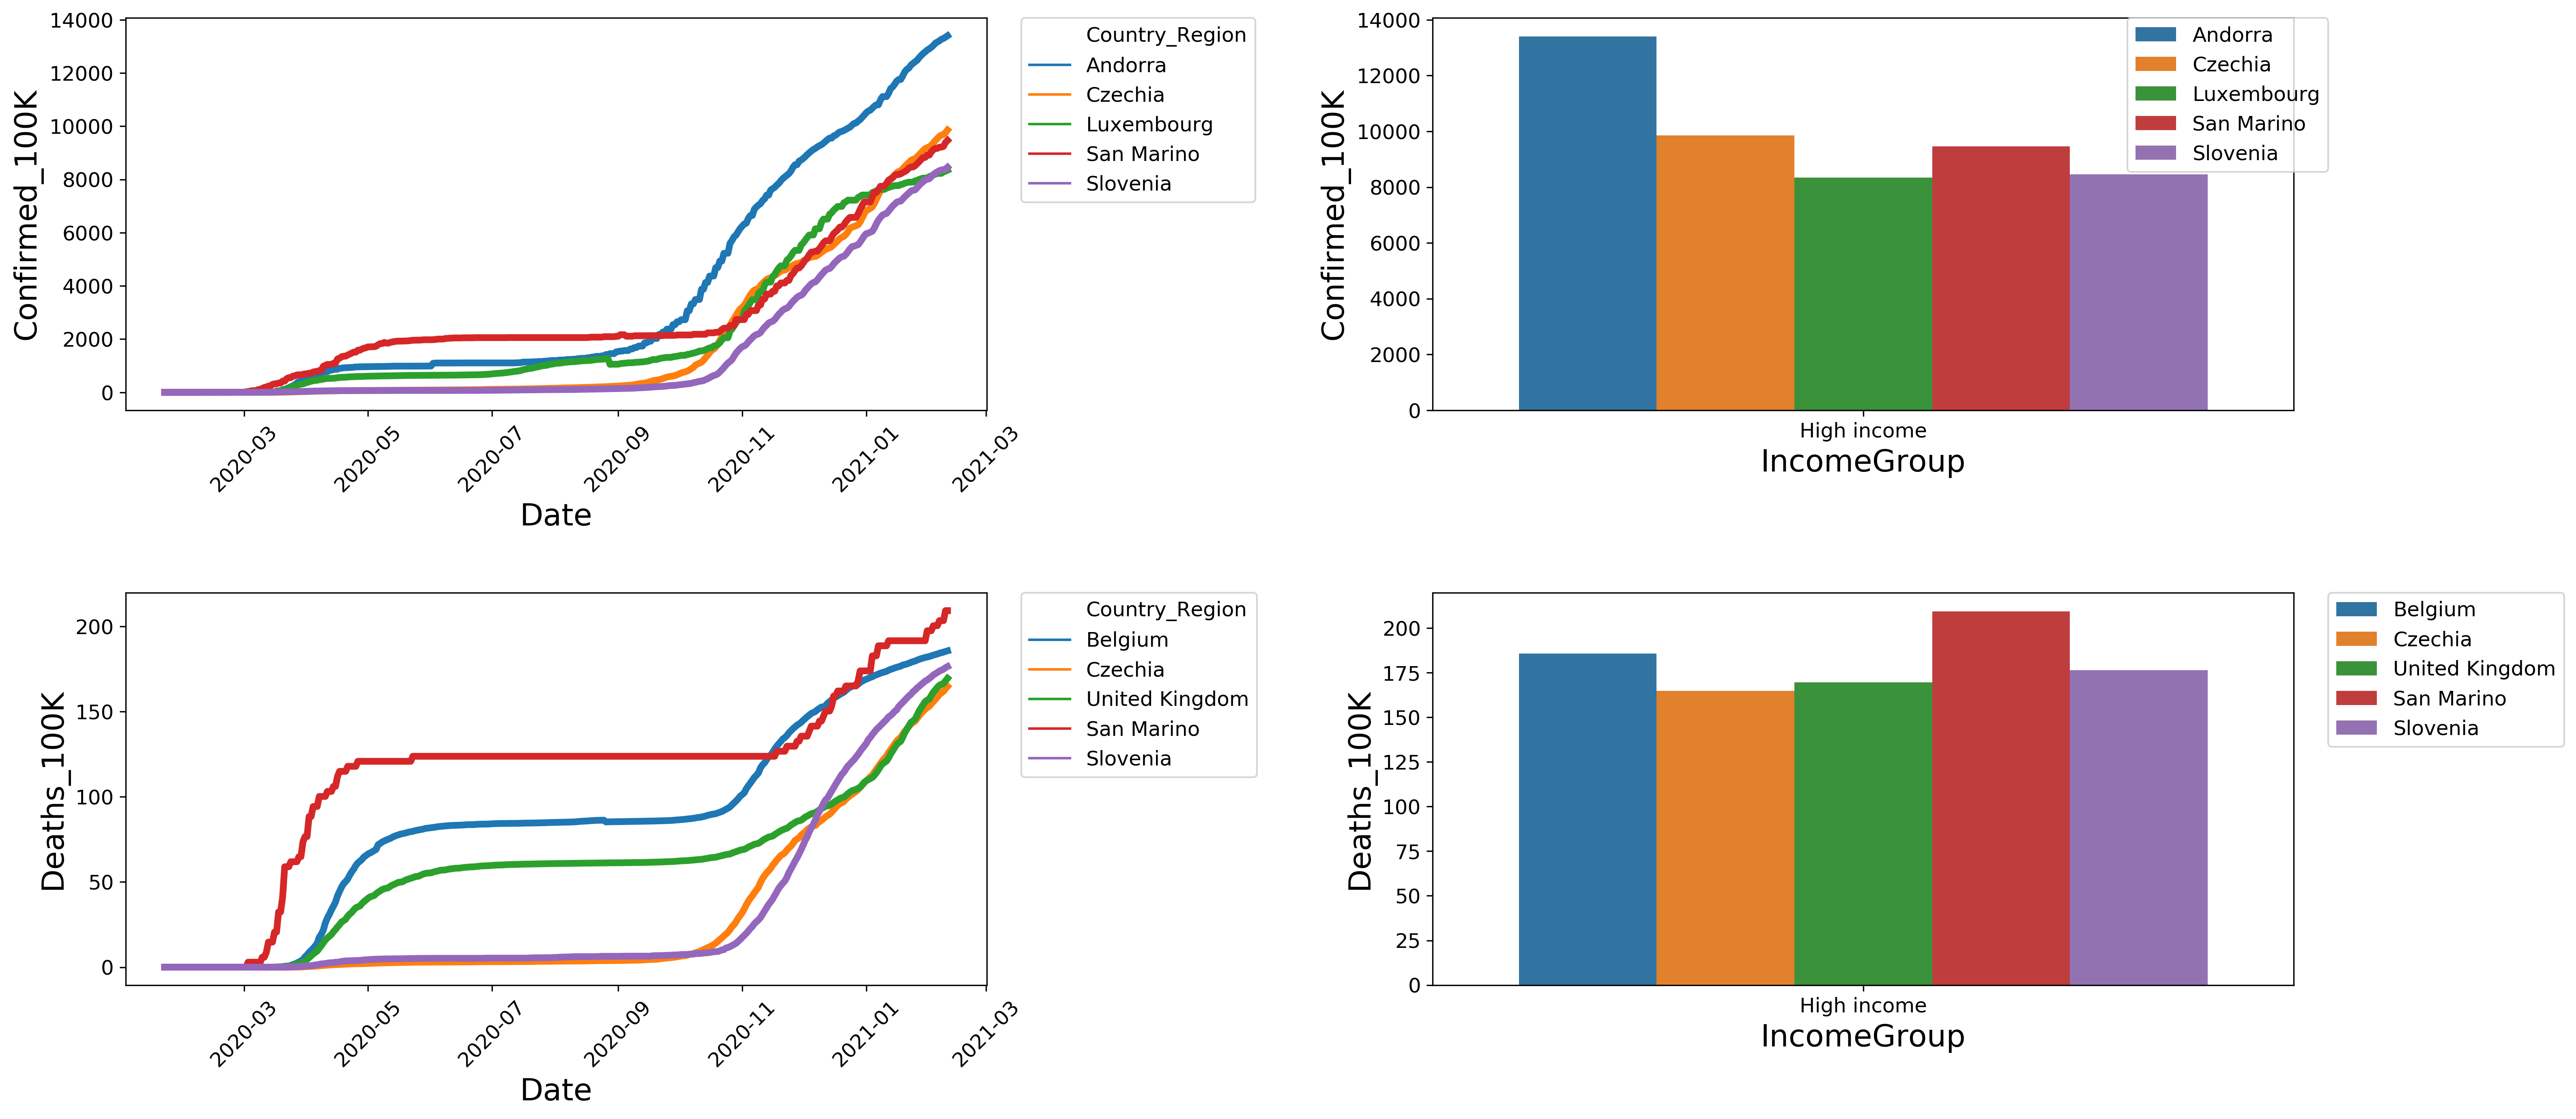

In [78]:
#find top 10 countries wiht highest numebr of deaths and confirmed cases (cumulative)
my_top = 5
top_deaths_100K = my_final_df.loc[last_reported_date].sort_values(by = "Deaths_100K", ascending = False).head(my_top).reset_index()['CountryCode'].to_list()#.set_index('CountryCode').to_dict()["Country_Region"]
top_confirmed_100K = my_final_df.loc[last_reported_date].sort_values(by = "Confirmed_100K", ascending = False).head(my_top).reset_index()['CountryCode'].to_list()#.set_index('CountryCode').to_dict()["Country_Region"]

top_deaths_100K_df = my_final_df[my_final_df['CountryCode'].isin(top_deaths_100K)].reset_index()
top_confirmed_100K_df = my_final_df[my_final_df['CountryCode'].isin(top_confirmed_100K)].reset_index()

# font = {'family' : 'normal',
#         'weight' : 'bold',
#         'size'   : 18}
# plt.rc('font', **font)

factor_size = 1.5
SMALL_SIZE = 8 * factor_size
MEDIUM_SIZE = 10 * factor_size
BIGGER_SIZE = 12 * factor_size

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Multiline Plot: number of confirmed cases in 100K 
fig1 = plt.figure(figsize=(22, 10) , dpi=300)


ax1 = fig1.add_subplot(221)
sb.lineplot(
    data=top_confirmed_100K_df, 
#     kind="line",
    x="Date", 
    y="Confirmed_100K",
    ax = ax1,
    linewidth = 4,
    hue="Country_Region")
plt.xticks(rotation=45) 
plt.legend(frameon=False)
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)
#plt.title('My title')

ax2 = fig1.add_subplot(222)
sb.barplot(
    data=top_confirmed_100K_df[top_confirmed_100K_df['Date'] == last_reported_date], 
    x="IncomeGroup", 
    y="Confirmed_100K",
    ax = ax2,
    hue="Country_Region")

plt.legend(frameon=False)
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)
ax3 = fig1.add_subplot(223)

sb.lineplot(
    data=top_deaths_100K_df, 
#     kind="line",
    x="Date", 
    y="Deaths_100K",
    linewidth = 4,
    ax = ax3,
    hue="Country_Region")
plt.xticks(rotation=45)
plt.legend(frameon=False)
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

ax4 = fig1.add_subplot(224)
sb.barplot(
    data=top_deaths_100K_df[top_deaths_100K_df['Date'] == last_reported_date], 
    x="IncomeGroup", 
    y="Deaths_100K",
    ax = ax4,
    hue="Country_Region")
plt.legend(frameon=False)
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

fig1.tight_layout(pad=3)

plt.savefig('Most_affected_countries.png')

## Plotting the top ten LESS affected countries and Inconme level


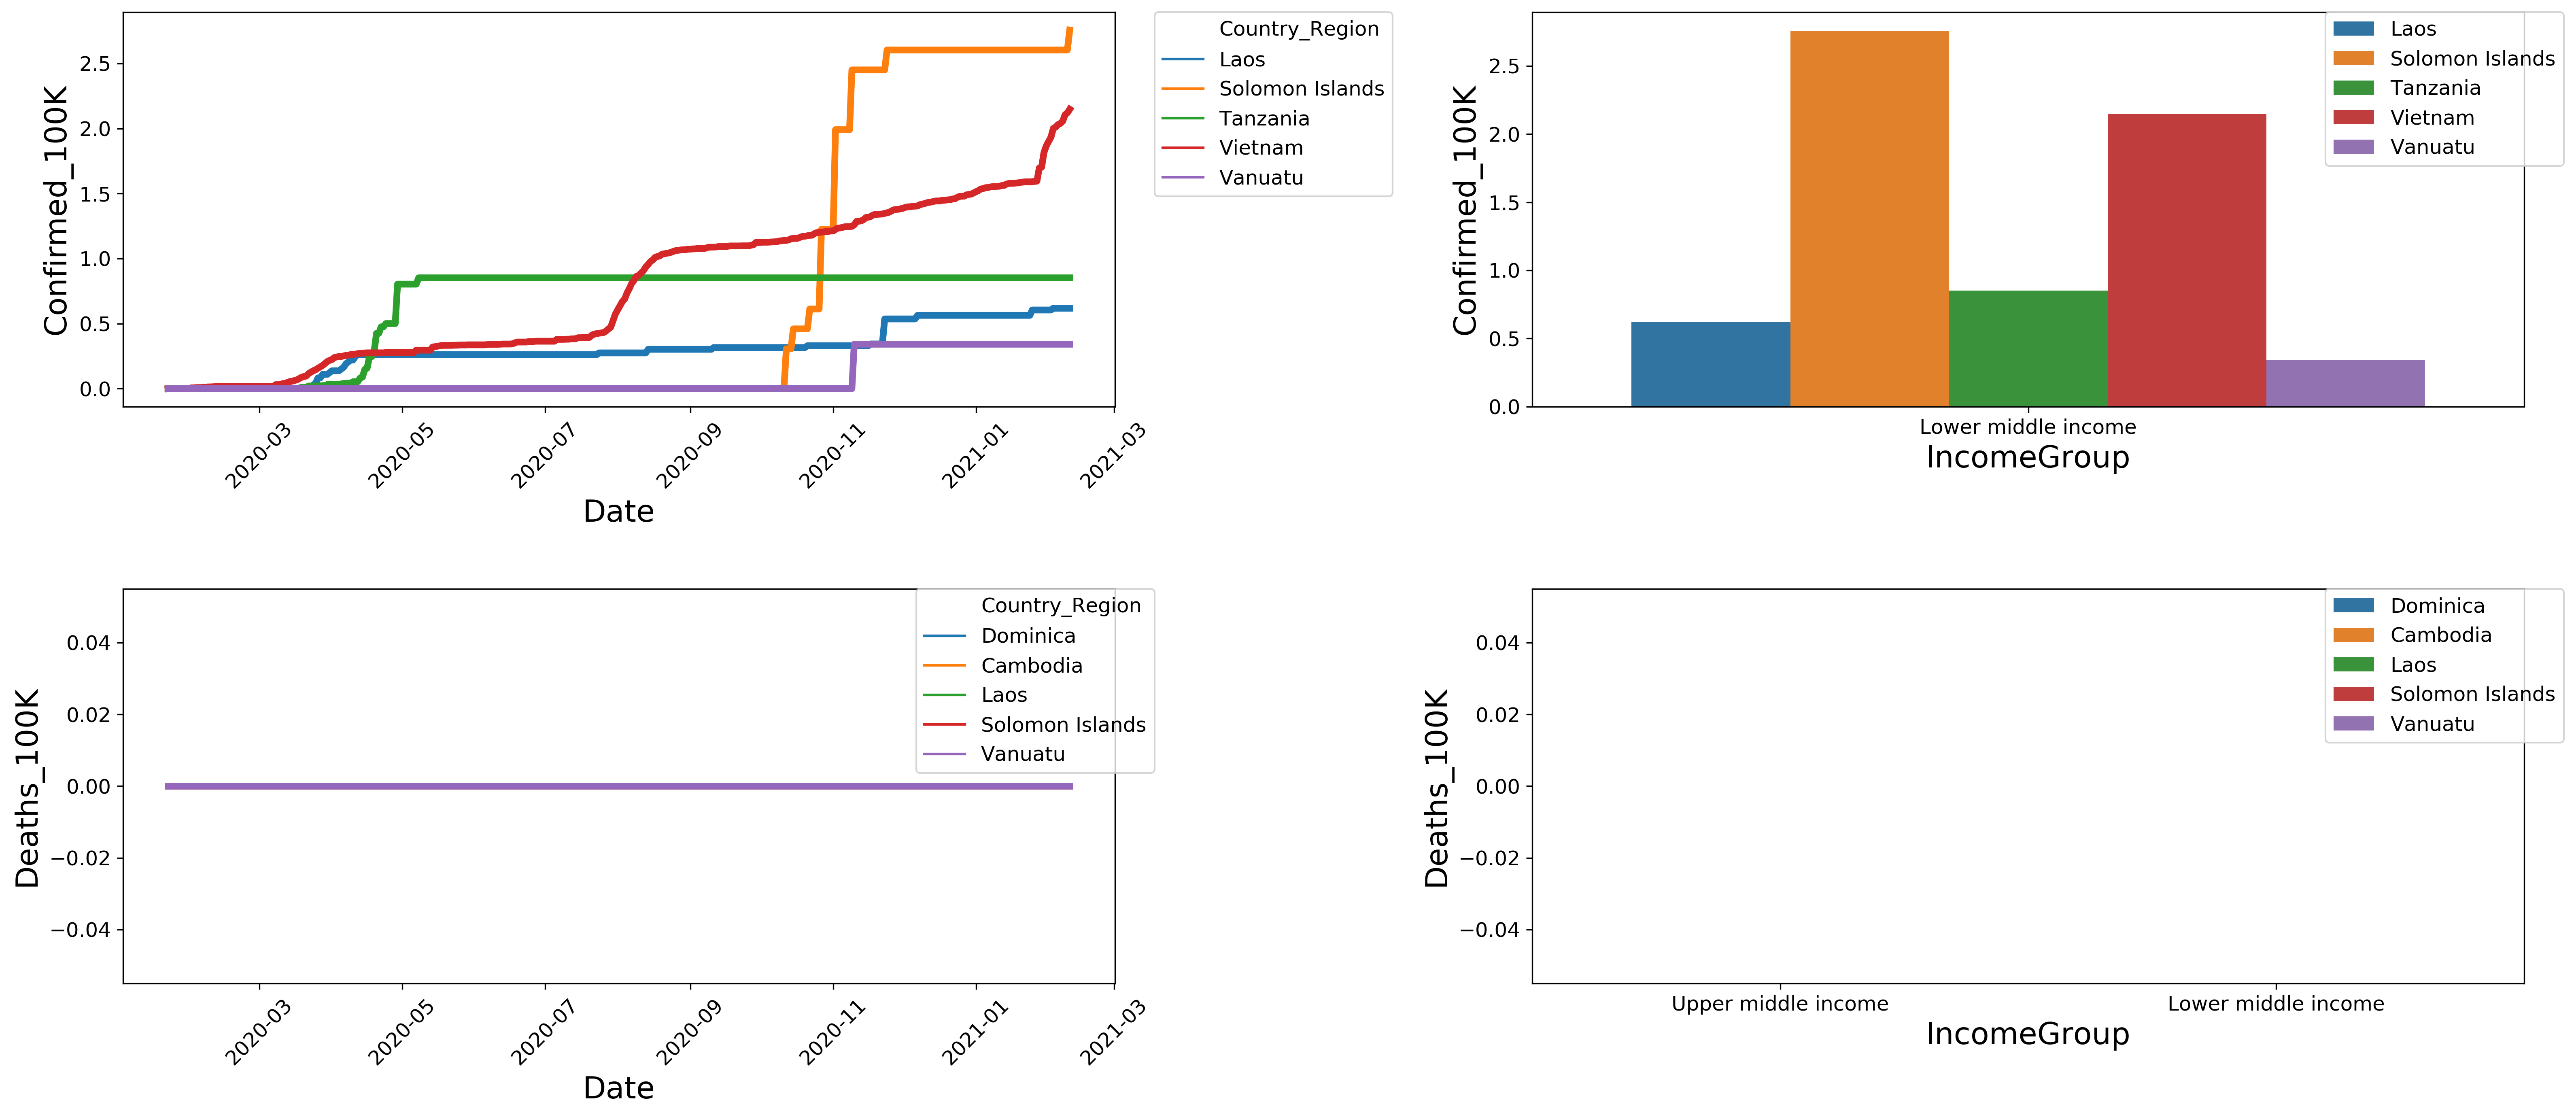

In [79]:
#find top 10 countries wiht highest numebr of deaths and confirmed cases (cumulative)
my_top_n = 5
top_deaths_100K = my_final_df.loc[last_reported_date].sort_values(by = "Deaths_100K", ascending = True).head(my_top_n).reset_index()['CountryCode'].to_list()#.set_index('CountryCode').to_dict()["Country_Region"]
top_confirmed_100K = my_final_df.loc[last_reported_date].sort_values(by = "Confirmed_100K", ascending = True).head(my_top_n).reset_index()['CountryCode'].to_list()#.set_index('CountryCode').to_dict()["Country_Region"]

top_deaths_100K_df = my_final_df.loc[my_final_df['CountryCode'].isin(top_deaths_100K)].reset_index()
top_confirmed_100K_df = my_final_df.loc[my_final_df['CountryCode'].isin(top_confirmed_100K)].reset_index()
# font = {'family' : 'normal',
#         'weight' : 'bold',
#         'size'   : 18}
# plt.rc('font', **font)

factor_size = 1.5
SMALL_SIZE = 8 * factor_size
MEDIUM_SIZE = 10 * factor_size
BIGGER_SIZE = 12 * factor_size

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Multiline Plot: number of confirmed cases in 100K 
fig1 = plt.figure(figsize=(22, 10) , dpi=300)


ax1 = fig1.add_subplot(221)
sb.lineplot(
    data=top_confirmed_100K_df, 
#     kind="line",
    x="Date", 
    y="Confirmed_100K",
    ax = ax1,
    linewidth = 4,
    hue="Country_Region")
plt.xticks(rotation=45) 
plt.legend(frameon=False)
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)
#plt.title('My title')

ax2 = fig1.add_subplot(222)
sb.barplot(
    data=top_confirmed_100K_df[top_confirmed_100K_df['Date'] == last_reported_date], 
    x="IncomeGroup", 
    y="Confirmed_100K",
    ax = ax2,
    hue="Country_Region")

plt.legend(frameon=False)
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)
ax3 = fig1.add_subplot(223)

sb.lineplot(
    data=top_deaths_100K_df, 
#     kind="line",
    x="Date", 
    y="Deaths_100K",
    linewidth = 4,
    ax = ax3,
    hue="Country_Region")
plt.xticks(rotation=45)
plt.legend(frameon=False)
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

ax4 = fig1.add_subplot(224)
sb.barplot(
    data=top_deaths_100K_df[top_deaths_100K_df['Date'] == last_reported_date], 
    x="IncomeGroup", 
    y="Deaths_100K",
    ax = ax4,
    hue="Country_Region")
plt.legend(frameon=False)
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

fig1.tight_layout(pad=3)

plt.savefig('Less_affected_countries.png')

## NOTE: We found that the less affected countries seem to be countries with missed information (no reported cases) or very small populated countries. 

## Beacuse of this, we remove countries with small population size (< 1e6 people)

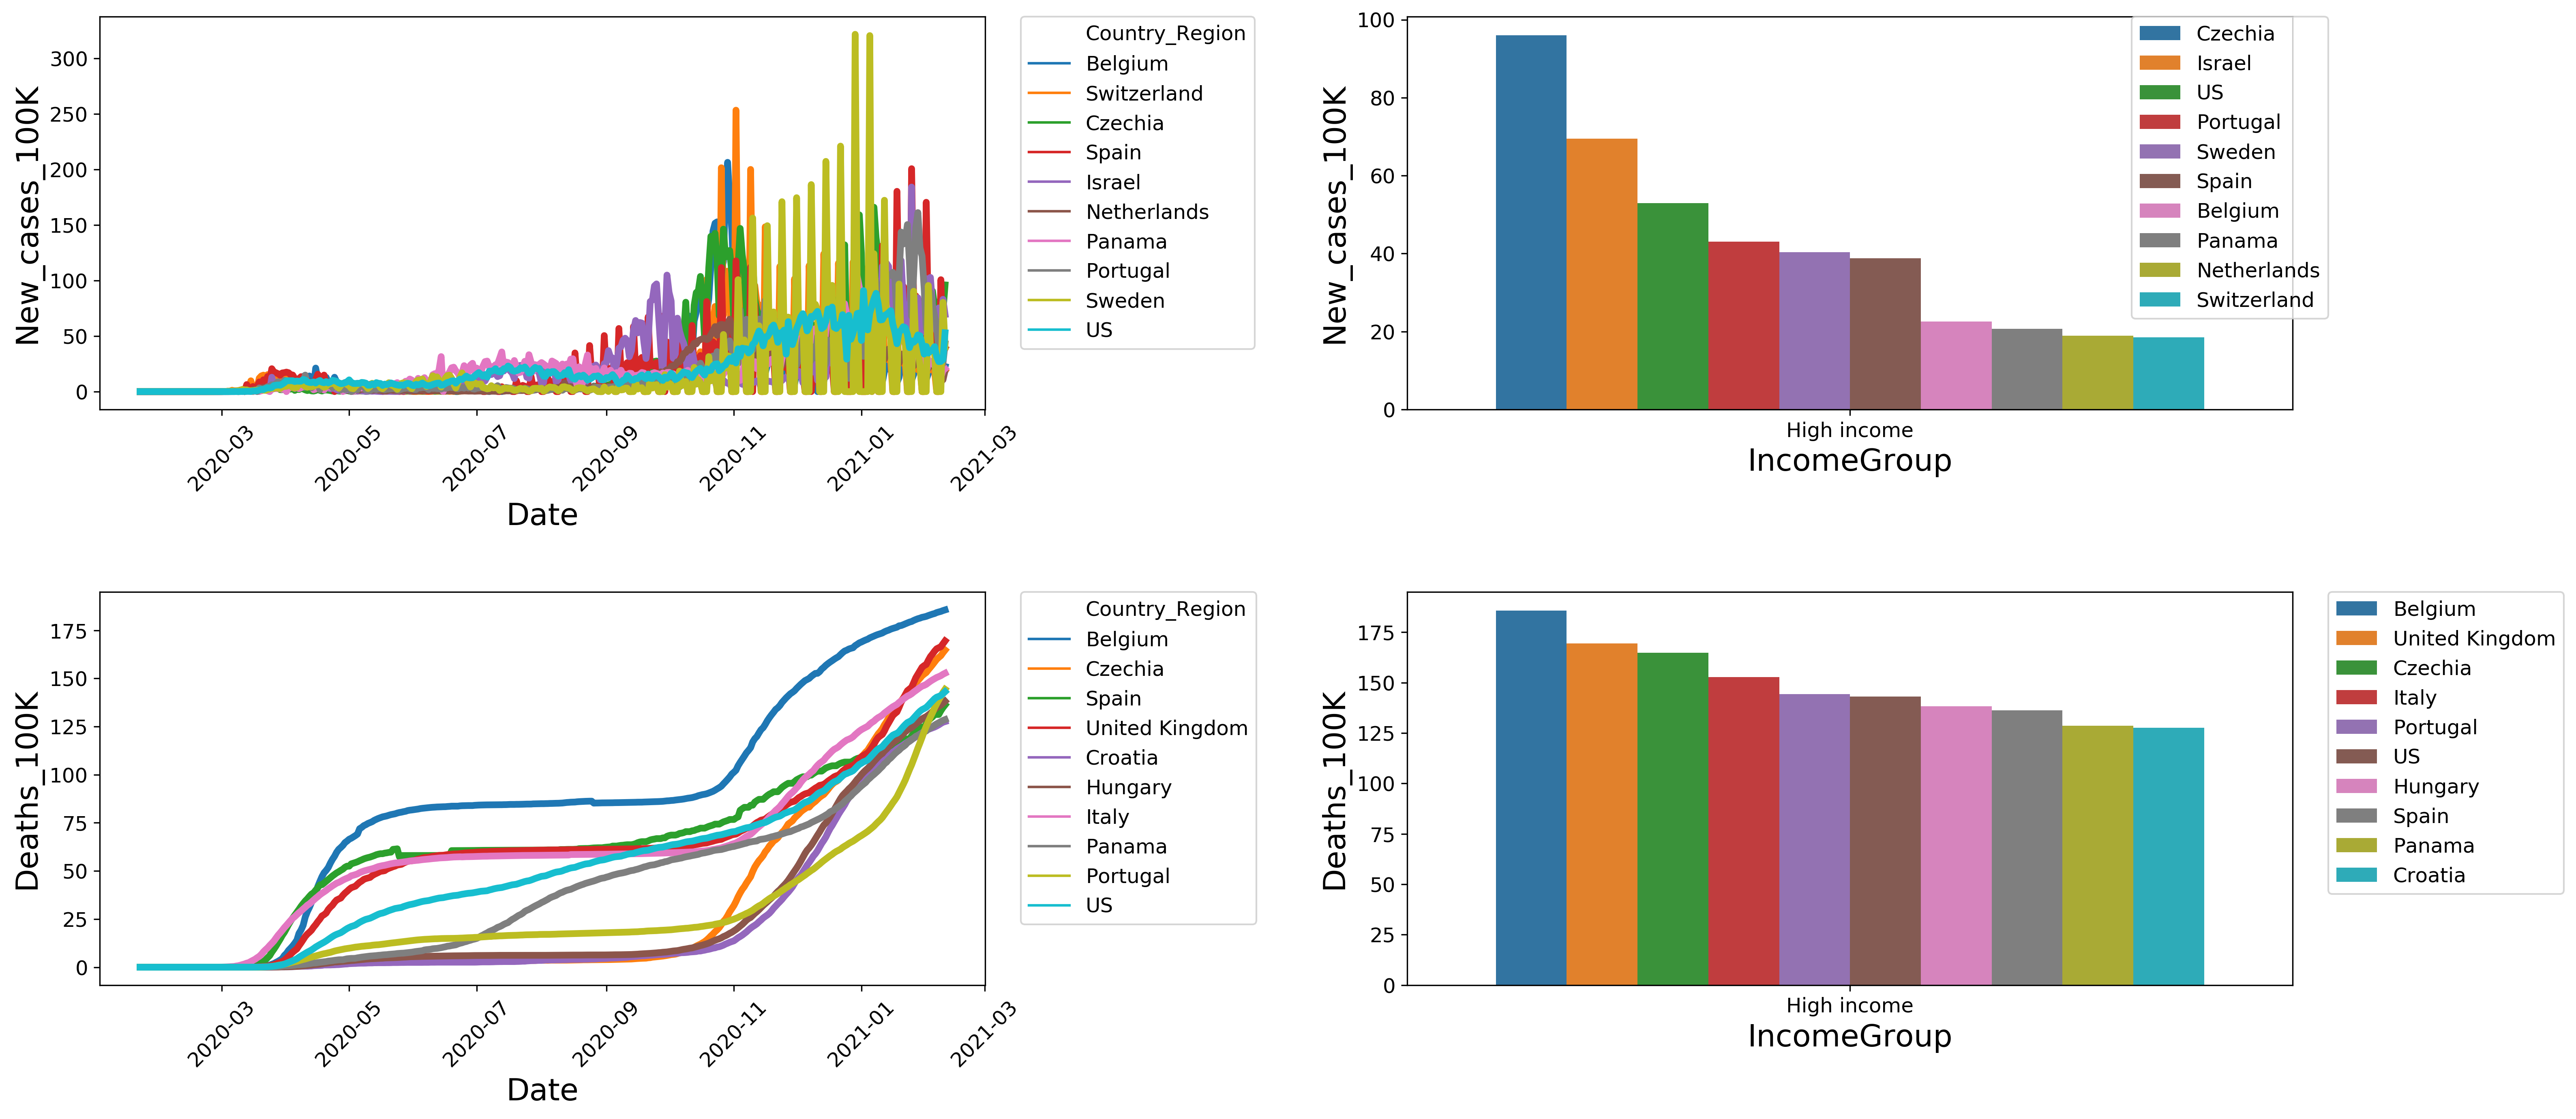

In [80]:
#find top 10 countries wiht highest numebr of deaths and confirmed cases (cumulative)
my_top_n = 10
filt_popul = 3e6
best_10_confirmed=my_final_df[(my_final_df['IncomeGroup'] == 'High income') & (my_final_df['Population'] >= filt_popul)].loc[last_reported_date].sort_values(by = "Confirmed_100K", ascending = False).head(my_top_n).reset_index()['CountryCode'].to_list()
best_10_deaths=my_final_df[(my_final_df['IncomeGroup'] == 'High income')& (my_final_df['Population'] >= filt_popul)].loc[last_reported_date].sort_values(by = "Deaths_100K", ascending = False).head(my_top_n).reset_index()['CountryCode'].to_list()

best_deaths_100K_df = my_final_df.loc[my_final_df['CountryCode'].isin(best_10_deaths)].reset_index()
best_confirmed_100K_df = my_final_df.loc[my_final_df['CountryCode'].isin(best_10_confirmed)].reset_index()

my_var_to_plot_row_1 = "New_cases_100K"
my_var_to_plot_row_2 = "Deaths_100K"




factor_size = 1.5
SMALL_SIZE = 8 * factor_size
MEDIUM_SIZE = 10 * factor_size
BIGGER_SIZE = 12 * factor_size

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Multiline Plot: number of confirmed cases in 100K 
fig1 = plt.figure(figsize=(22, 10) , dpi=300)


ax1 = fig1.add_subplot(221)
sb.lineplot(
    data=best_confirmed_100K_df, 
#     kind="line",
    x="Date", 
    #y="Confirmed_100K",
    y=my_var_to_plot_row_1,
    ax = ax1,
    linewidth = 4,
    hue="Country_Region")
plt.xticks(rotation=45) 
plt.legend(frameon=False)
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)
#plt.title('My title')

ax2 = fig1.add_subplot(222)
sb.barplot(
    data=best_confirmed_100K_df[best_confirmed_100K_df['Date'] == last_reported_date].sort_values(by = my_var_to_plot_row_1, ascending = False), 
    x="IncomeGroup", 
    y=my_var_to_plot_row_1,
    ax = ax2,
    hue="Country_Region")

plt.legend(frameon=False)
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)
ax3 = fig1.add_subplot(223)

sb.lineplot(
    data=best_deaths_100K_df, 
#     kind="line",
    x="Date", 
    y=my_var_to_plot_row_2,
    linewidth = 4,
    ax = ax3,
    hue="Country_Region")
plt.xticks(rotation=45)
plt.legend(frameon=False)
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

ax4 = fig1.add_subplot(224)
sb.barplot(
    data=best_deaths_100K_df[best_deaths_100K_df['Date'] == last_reported_date].sort_values(by = my_var_to_plot_row_2, ascending = False), 
    x="IncomeGroup", 
    y=my_var_to_plot_row_2,
    ax = ax4,
    hue="Country_Region")
plt.legend(frameon=False)
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

fig1.tight_layout(pad=3)

plt.savefig('Real_Less_affected_countries.png')

In [81]:
my_var_to_plot_row_3 = my_final_df.columns.to_list()[5:19]
my_var_to_plot_row_3

['Confirmed',
 'Deaths',
 'Recovered',
 'Active',
 'New_cases',
 'New_deaths',
 'New_recovered',
 'Confirmed_100K',
 'Deaths_100K',
 'Recovered_100K',
 'Active_100K',
 'New_cases_100K',
 'New_deaths_100K',
 'New_recovered_100K']

## Checking the High income countries and find out what is the best stringency index pattern

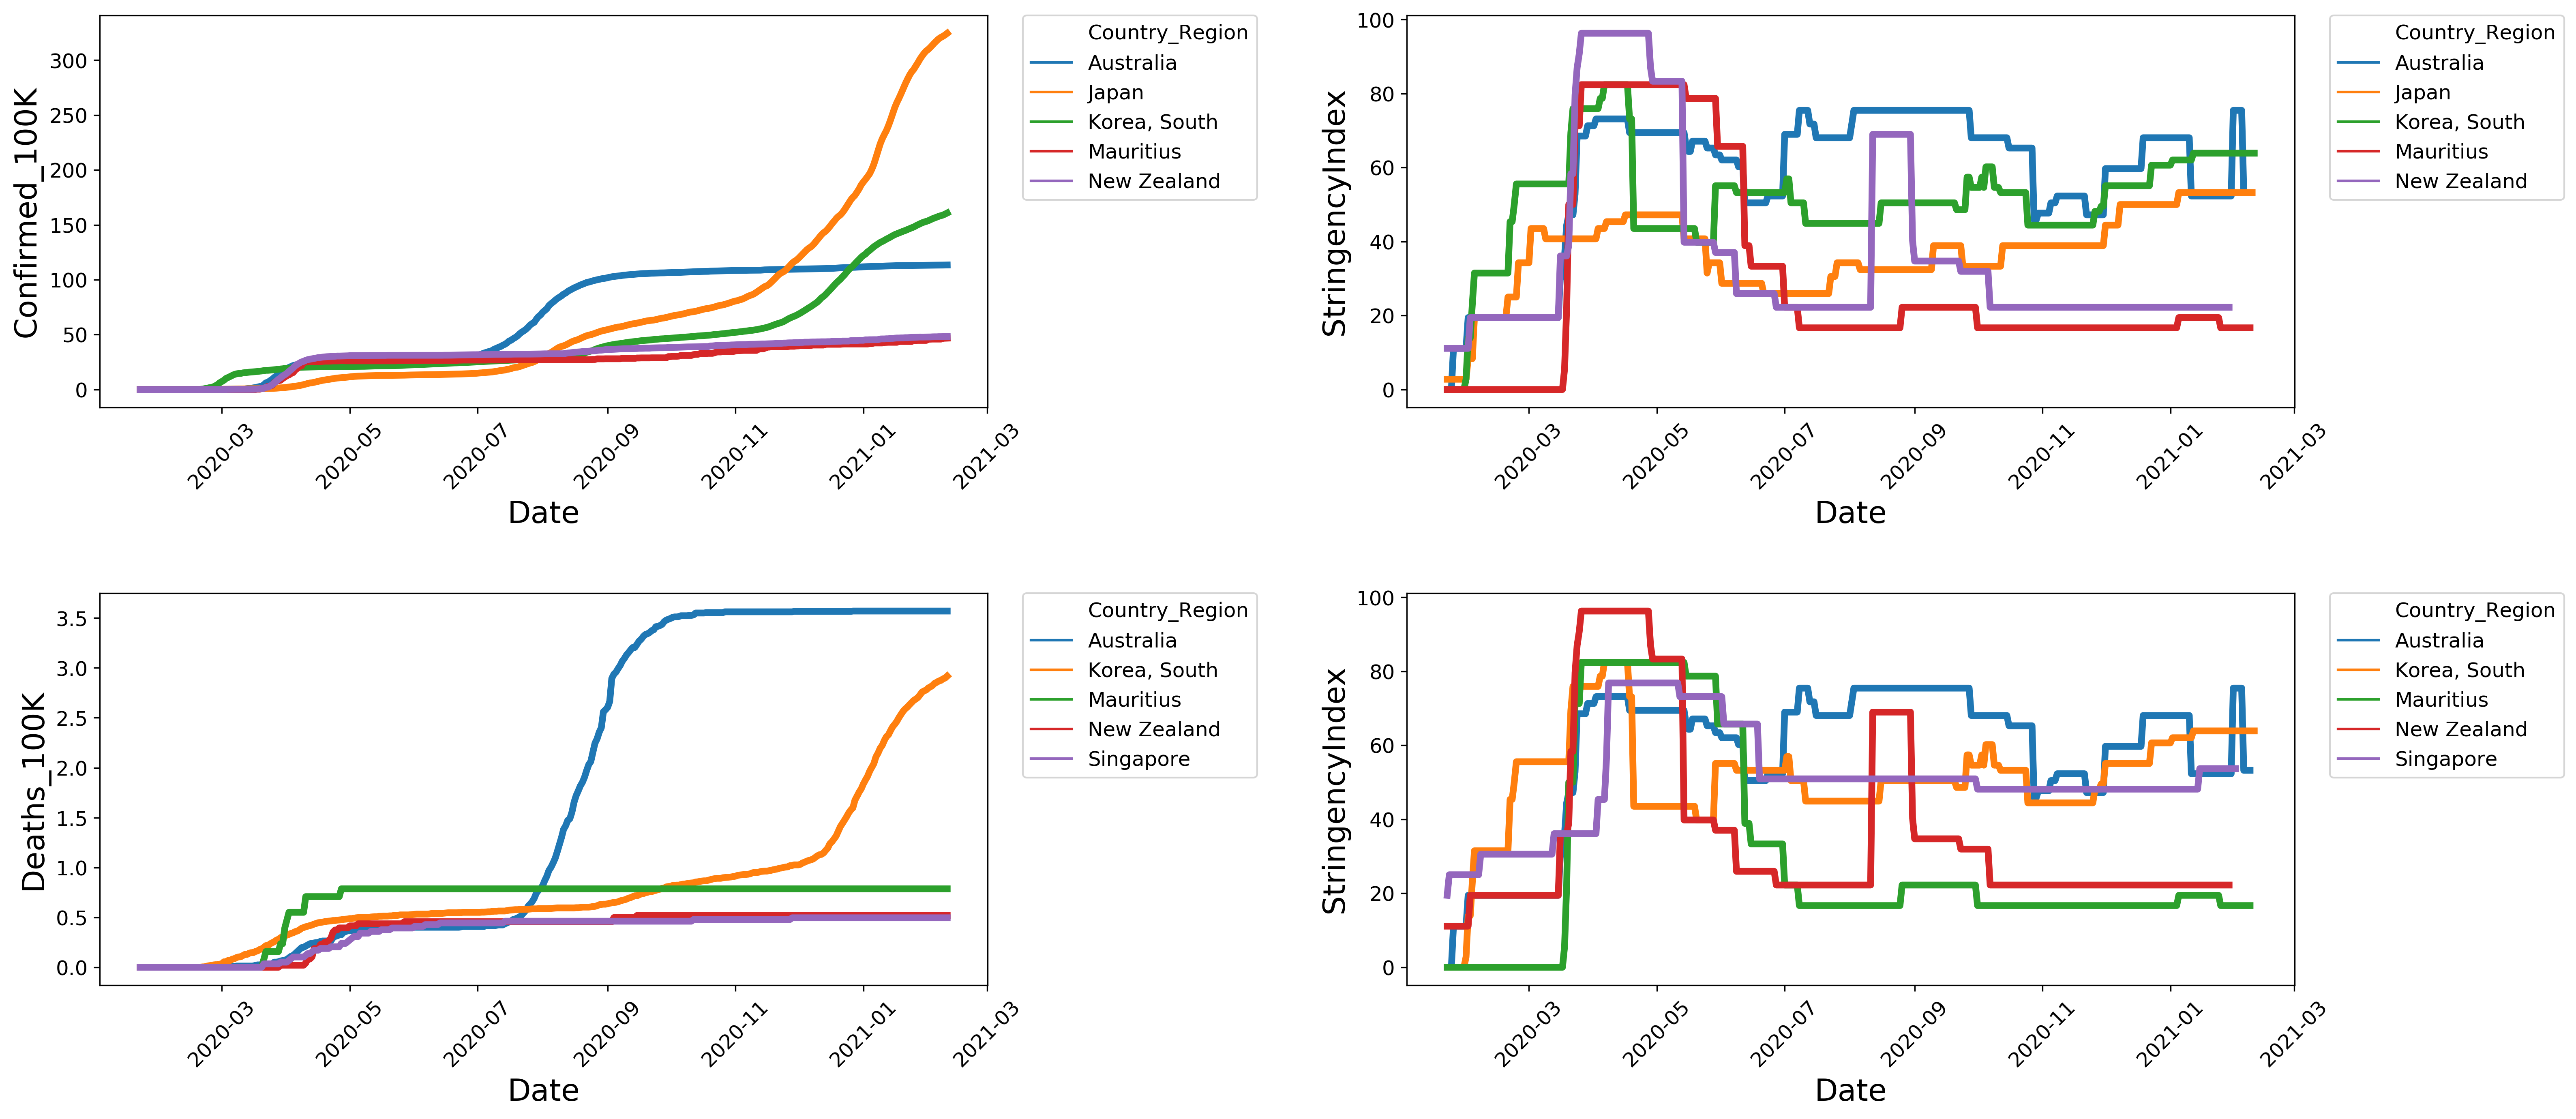

In [82]:
#find top 10 countries wiht highest numebr of deaths and confirmed cases (cumulative)
my_top_n = 5

best_10_confirmed=my_final_df[(my_final_df['IncomeGroup'] == 'High income') & (my_final_df['Population'] >= 1000000)].loc[last_reported_date].sort_values(by = "Confirmed_100K", ascending = True).head(my_top_n).reset_index()['CountryCode'].to_list()
best_10_deaths=my_final_df[(my_final_df['IncomeGroup'] == 'High income') & (my_final_df['Population'] >= 1000000)].loc[last_reported_date].sort_values(by = "Deaths_100K", ascending = True).head(my_top_n).reset_index()['CountryCode'].to_list()

best_deaths_100K_df = my_final_df.loc[my_final_df['CountryCode'].isin(best_10_deaths)].reset_index()
best_confirmed_100K_df = my_final_df.loc[my_final_df['CountryCode'].isin(best_10_confirmed)].reset_index()



factor_size = 1.5
SMALL_SIZE = 8 * factor_size
MEDIUM_SIZE = 10 * factor_size
BIGGER_SIZE = 12 * factor_size

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Multiline Plot: number of confirmed cases in 100K 
fig1 = plt.figure(figsize=(22, 10) , dpi=300)


ax1 = fig1.add_subplot(221)
sb.lineplot(
    data=best_confirmed_100K_df, 
#     kind="line",
    x="Date", 
    y="Confirmed_100K",
    ax = ax1,
    linewidth = 4,
    hue="Country_Region")
plt.xticks(rotation=45) 
plt.legend(frameon=False)
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)
#plt.title('My title')

ax2 = fig1.add_subplot(222)
sb.lineplot(
    data=best_confirmed_100K_df, 
#     kind="line",
    x="Date", 
    y="StringencyIndex",
    ax = ax2,
    linewidth = 4,
    hue="Country_Region")
plt.xticks(rotation=45) 
plt.legend(frameon=False)
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

ax3 = fig1.add_subplot(223)
sb.lineplot(
    data=best_deaths_100K_df, 
#     kind="line",
    x="Date", 
    y="Deaths_100K",
    linewidth = 4,
    ax = ax3,
    hue="Country_Region")
plt.xticks(rotation=45)
plt.legend(frameon=False)
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

ax4 = fig1.add_subplot(224)
sb.lineplot(
    data=best_deaths_100K_df, 
#     kind="line",
    x="Date", 
    y="StringencyIndex",
    ax = ax4,
    linewidth = 4,
    hue="Country_Region")
plt.xticks(rotation=45) 
plt.legend(frameon=False)
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

fig1.tight_layout(pad=3)

plt.savefig('best_perfarmance.png')

# END

# Experimental

In [81]:
#find last reported date
last_reported_date = my_final_df.reset_index().tail(1)['Date'].to_string(index = False)
last_reported_date

'2021-04-24'

In [94]:
my_var_to_plot = my_final_df.columns.to_list()[12:19]
my_var_to_plot

['Confirmed_100K',
 'Deaths_100K',
 'Recovered_100K',
 'Active_100K',
 'New_cases_100K',
 'New_deaths_100K',
 'New_recovered_100K']

In [78]:
my_var_to_plot[0]

'Confirmed'

In [79]:
my_top_n = 10
filt_popul = 3e6

In [82]:
my_final_df[ (my_final_df['Population'] >= filt_popul)].loc[last_reported_date].sort_values(by = "Confirmed", ascending = False).head(my_top_n)#.reset_index()['CountryCode'].to_list()


CountryCode  StringencyIndex StringencyIndex_factor  \
Date                                                             
2021-04-24         USA              NaN                unknown   
2021-04-24         IND              NaN                unknown   
2021-04-24         BRA              NaN                unknown   
2021-04-24         FRA              NaN                unknown   
2021-04-24         RUS              NaN                unknown   
2021-04-24         TUR              NaN                unknown   
2021-04-24         GBR              NaN                unknown   
2021-04-24         ITA              NaN                unknown   
2021-04-24         ESP              NaN                unknown   
2021-04-24         DEU             75.0                   High   

            Country_Region    Population   Confirmed    Deaths   Recovered  \
Date                                                                         
2021-04-24              US  3.294663e+08  32045113.0  571921.0         0.0   
2021-04-24           India  1.380004e+09  16960172.0  192311.0  14085110.0   
2021-04-24          Brazil  2.125594e+08  14308215.0  389492.0  12606011.0   
2021-04-24          France  6.527351e+07   5534656.0  102872.0    337667.0   
2021-04-24          Russia  1.459345e+08   4699988.0  106108.0   4330610.0   
2021-04-24          Turkey  8.433907e+07   4591416.0   38011.0   4022408.0   
2021-04-24  United Kingdom  6.788600e+07   4418710.0  127670.0     14388.0   
2021-04-24           Italy  6.046183e+07   3949517.0  119021.0   3369048.0   
2021-04-24           Spain  4.675478e+07   3468617.0   77591.0    150376.0   
2021-04-24         Germany  8.378394e+07   3291293.0   81610.0   2902900.0   

                Active  New_cases  ...  New_recovered  Confirmed_100K  \
Date                               ...                                  
2021-04-24  31473192.0    53363.0  ...            0.0     9726.370999   
2021-04-24   2682751.0   349691.0  ...       217113.0     1228.994066   
2021-04-24   1312712.0    71137.0  ...        19739.0     6731.395739   
2021-04-24   5094117.0    32642.0  ...         1433.0     8479.176055   
2021-04-24    263270.0     8698.0  ...         9133.0     3220.615611   
2021-04-24    530997.0    40596.0  ...        52297.0     5443.996671   
2021-04-24   4276652.0     2122.0  ...          107.0     6509.014730   
2021-04-24    461448.0    13814.0  ...        17587.0     6532.248744   
2021-04-24   3240650.0        0.0  ...            0.0     7418.742592   
2021-04-24    306783.0    14422.0  ...        26210.0     3928.309893   

            Deaths_100K  Recovered_100K  Active_100K  New_cases_100K  \
Date                                                                   
2021-04-24   173.590145        0.000000  9552.780853       16.196802   
2021-04-24    13.935535     1020.656902   194.401629       25.339847   
2021-04-24   183.239124     5930.582447   617.574167       33.466879   
2021-04-24   157.601448      517.310912  7804.263696       50.008034   
2021-04-24    72.709352     2967.503357   180.402901        5.960210   
2021-04-24    45.069268     4769.329497   629.597906       48.134277   
2021-04-24   188.065275       21.194354  6299.755101        3.125828   
2021-04-24   196.853129     5572.190110   763.205505       22.847473   
2021-04-24   165.953075      321.626987  6931.162529        0.000000   
2021-04-24    97.405296     3464.744946   366.159650       17.213322   

            New_deaths_100K  New_recovered_100K    GDP_in_USD  \
Date                                                            
2021-04-24         0.219749            0.000000  2.143323e+13   
2021-04-24         0.200507           15.732776  2.868929e+12   
2021-04-24         1.447125            9.286345  1.839758e+12   
2021-04-24         0.332447            2.195378  2.715518e+12   
2021-04-24         0.267243            6.258289  1.699877e+12   
2021-04-24         0.401949           62.008037  7.614255e+11   
2021-04-24         

In [83]:
def sort_df_by(a_df, sorted_by, my_top = my_top_n, date = last_reported_date, popul = filt_popul):
    my_countries = a_df[ (a_df['Population'] >= popul)].loc[date].sort_values(by = sorted_by, ascending = False).head(my_top).reset_index()['CountryCode'].to_list()# select the names of the countries you want for later filtering
    a_df = a_df.loc[a_df['CountryCode'].isin(my_countries)]#.reset_index()

    return(a_df)



In [84]:
last_reported_date

'2021-04-24'

In [85]:
sort_df_by(a_df = my_final_df, 
#            my_top = 5,
#            date = last_reported_date,
           sorted_by = my_var_to_plot[4])

CountryCode  StringencyIndex StringencyIndex_factor Country_Region  \
Date                                                                            
2020-01-22         ARG             0.00               Very_low      Argentina   
2020-01-23         ARG            11.11               Very_low      Argentina   
2020-01-24         ARG            11.11               Very_low      Argentina   
2020-01-25         ARG            11.11               Very_low      Argentina   
2020-01-26         ARG            11.11               Very_low      Argentina   
...                ...              ...                    ...            ...   
2021-04-20         USA            56.94                 Middle             US   
2021-04-21         USA              NaN                unknown             US   
2021-04-22         USA              NaN                unknown             US   
2021-04-23         USA              NaN                unknown             US   
2021-04-24         USA              NaN                unknown             US   

             Population   Confirmed    Deaths  Recovered      Active  \
Date                                                                   
2020-01-22   45195777.0         0.0       0.0        0.0         0.0   
2020-01-23   45195777.0         0.0       0.0        0.0         0.0   
2020-01-24   45195777.0         0.0       0.0        0.0         0.0   
2020-01-25   45195777.0         0.0       0.0        0.0         0.0   
2020-01-26   45195777.0         0.0       0.0        0.0         0.0   
...                 ...         ...       ...        ...         ...   
2021-04-20  329466283.0  31799237.0  568560.0        0.0  31230677.0   
2021-04-21  329466283.0  31862094.0  569402.0        0.0  31292692.0   
2021-04-22  329466283.0  31929351.0  570345.0        0.0  31359006.0   
2021-04-23  329466283.0  31991750.0  571197.0        0.0  31420553.0   
2021-04-24  329466283.0  32045113.0  571921.0        0.0  31473192.0   

            New_cases  ...  New_recovered  Confirmed_100K  Deaths_100K  \
Date                   ...                                               
2020-01-22        0.0  ...            0.0        0.000000     0.000000   
2020-01-23        0.0  ...            0.0        0.000000     0.000000   
2020-01-24        0.0  ...            0.0        0.000000     0.000000   
2020-01-25        0.0  ...            0.0        0.000000     0.000000   
2020-01-26        0.0  ...            0.0        0.000000     0.000000   
...               ...  ...            ...             ...          ...   
2021-04-20    61273.0  ...            0.0     9651.742421   172.570011   
2021-04-21    62857.0  ...            0.0     9670.820853   172.825576   
2021-04-22    67257.0  ...            0.0     9691.234778   173.111796   
2021-04-23    62399.0  ...            0.0     9710.174197   173.370396   
2021-04-24    53363.0  ...            0.0     9726.370999   173.590145   

            Recovered_100K  Active_100K  New_cases_100K  New_deaths_100K  \
Date                                                                       
2020-01-22             0.0     0.000000        0.000000         0.000000   
2020-01-23             0.0     0.000000        0.000000         0.000000   
2020-01-24             0.0     0.000000        0.000000         0.000000   
2020-01-25             0.0     0.000000        0.000000         0.000000   
2020-01-26             0.0     0.000000        0.000000         0.000000   
...                    ...          ...             ...              ...   
2021-04-20             0.0  9479.172410       18.597654         0.250101   
2021-04-21             0.0  9497.995277       19.078432         0.255565   
2021-04-22             0.0  9518.122982       20.413925         0.286220   
2021-04-23             0.0  9536.803801       18.939419         0.258600   
2021-04-24             0.0  9552.780853       16.196802         0.219749   

            New_recovered_100K    GDP_in_USD          IncomeGroup  


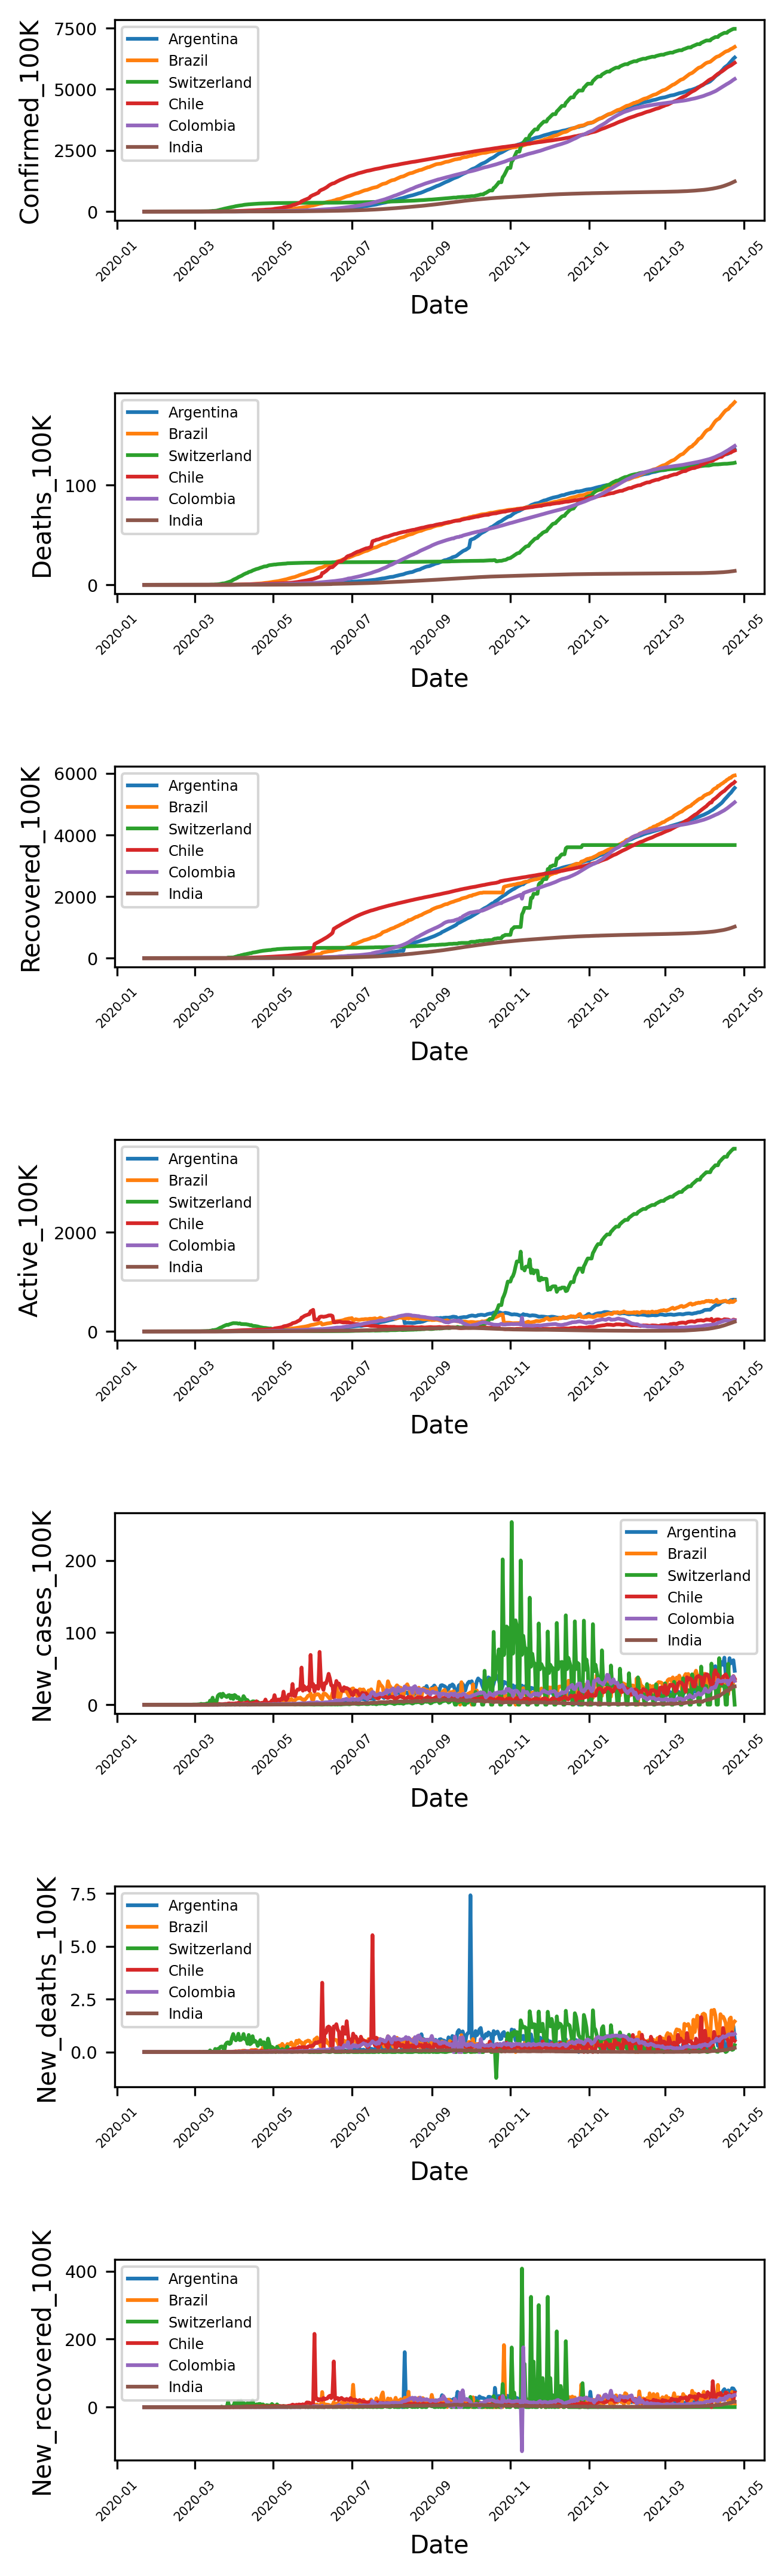

In [145]:
fig1 = plt.figure(figsize=(5, 15), dpi = 300)
my_line_width = 1.5
top_countries = 10
my_df = my_final_df[my_final_df["CountryCode"].isin(["ARG", "COL", "CHL", "BRA", "CHE", "GER", "IND"])]
    

for n in range(len(my_var_to_plot)):
#     my_df = sort_df_by(a_df = my_final_df, my_top = top_countries, sorted_by = my_var_to_plot[n])
    ax = fig1.add_subplot(7, 1, n + 1)
    sb.lineplot(data=my_df.reset_index(),
                x="Date",
                y=my_var_to_plot[n],
                linewidth = my_line_width,
                hue="Country_Region")
    plt.legend(fontsize='xx-small', title_fontsize='x-small')
    plt.xticks(rotation=45, fontsize=5)
    plt.yticks(fontsize='x-small')


fig1.tight_layout(pad=3)


In [87]:
def my_multiplots_func(my_df, my_vars, dim = 4):
    fig1 = plt.figure(figsize=(22, 10) , dpi=300)
    #print(dim)
    my_axes = []
    for my_var in range(len(my_vars)):
        #my_axes.append(fig1.add_subplot(dim, dim, n + 1))
        ax = fig1.add_subplot(dim, dim, my_var + 1)
        
    #for my_var in range(len(my_vars)):
        
        
        
#     for my_var in range(len(my_vars)):
#         ax[my_var + 1] = fig1.add_subplot(dim, dim, my_var + 1)
#         my_df = sort_df_by(a_df = my_df, 
#                            sorted_by = my_vars[my_var])
#         fig1.add_subplot(dim, dim, my_var + 1)
#         sb.lineplot(
#         data=best_confirmed_100K_df, 
#         #     kind="line",
#         x="Date", 
#         #y="Confirmed_100K",
#         y=my_var_to_plot[0],
#         ax = ax[my_var + 1],
#         linewidth = my_line_width,
#         hue="Country_Region")
    
    
    #fig1 = plt.figure(figsize=(22, 10) , dpi=300)
    
    return(fig1)
# for my_vars in my_var_to_plot:
#     print(my_vars)

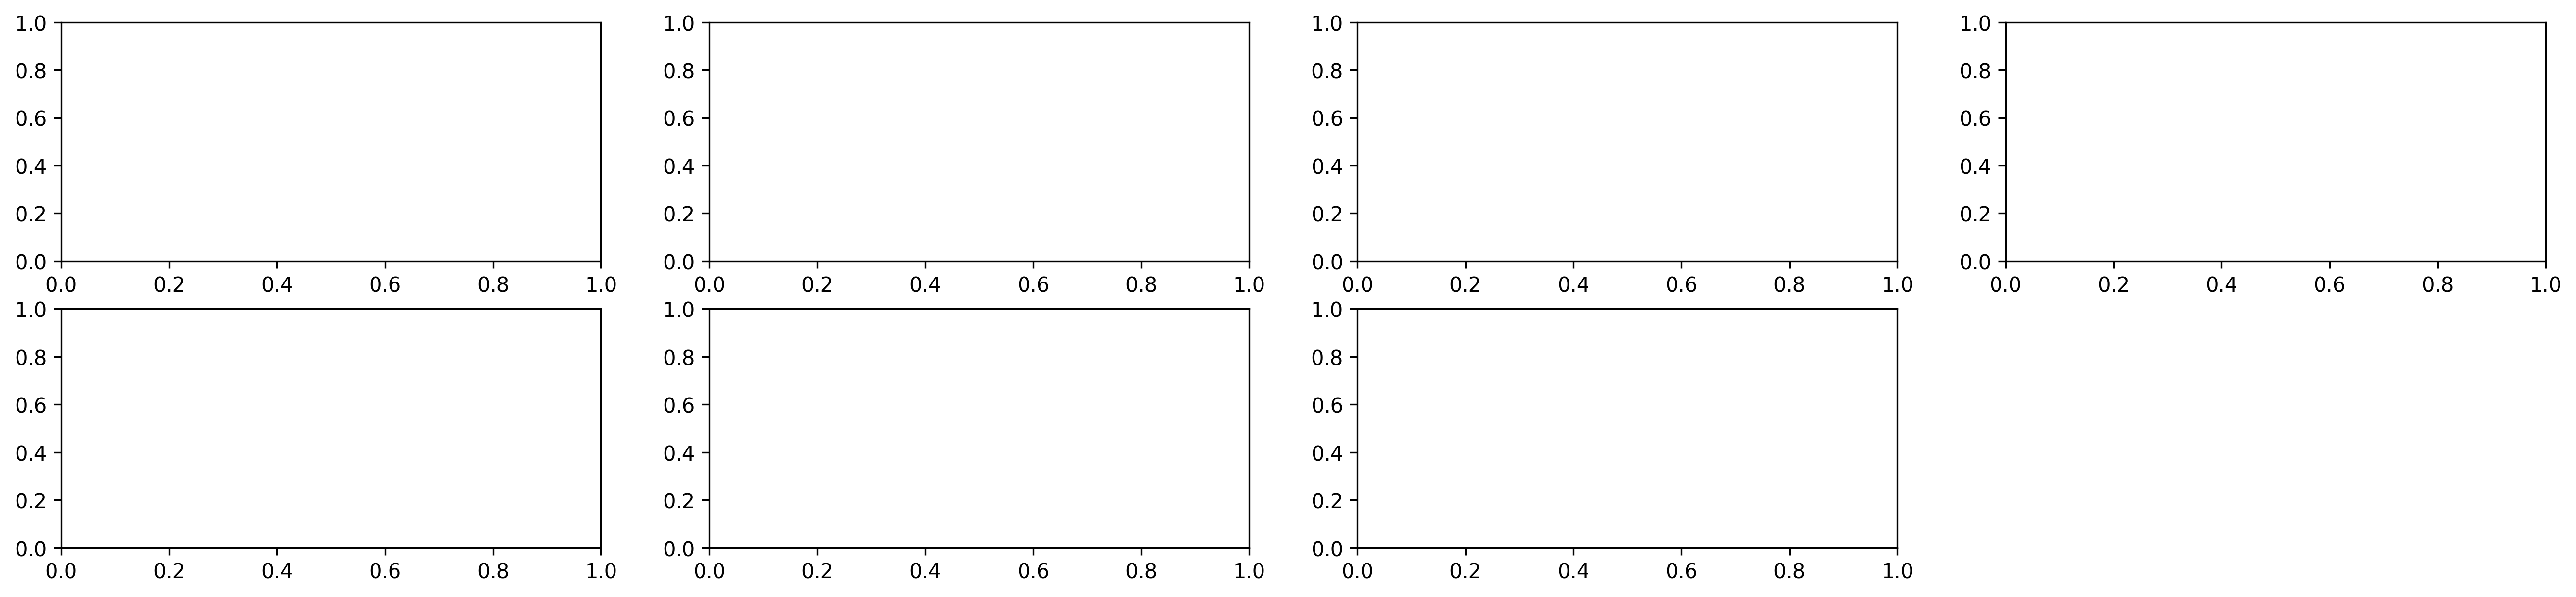

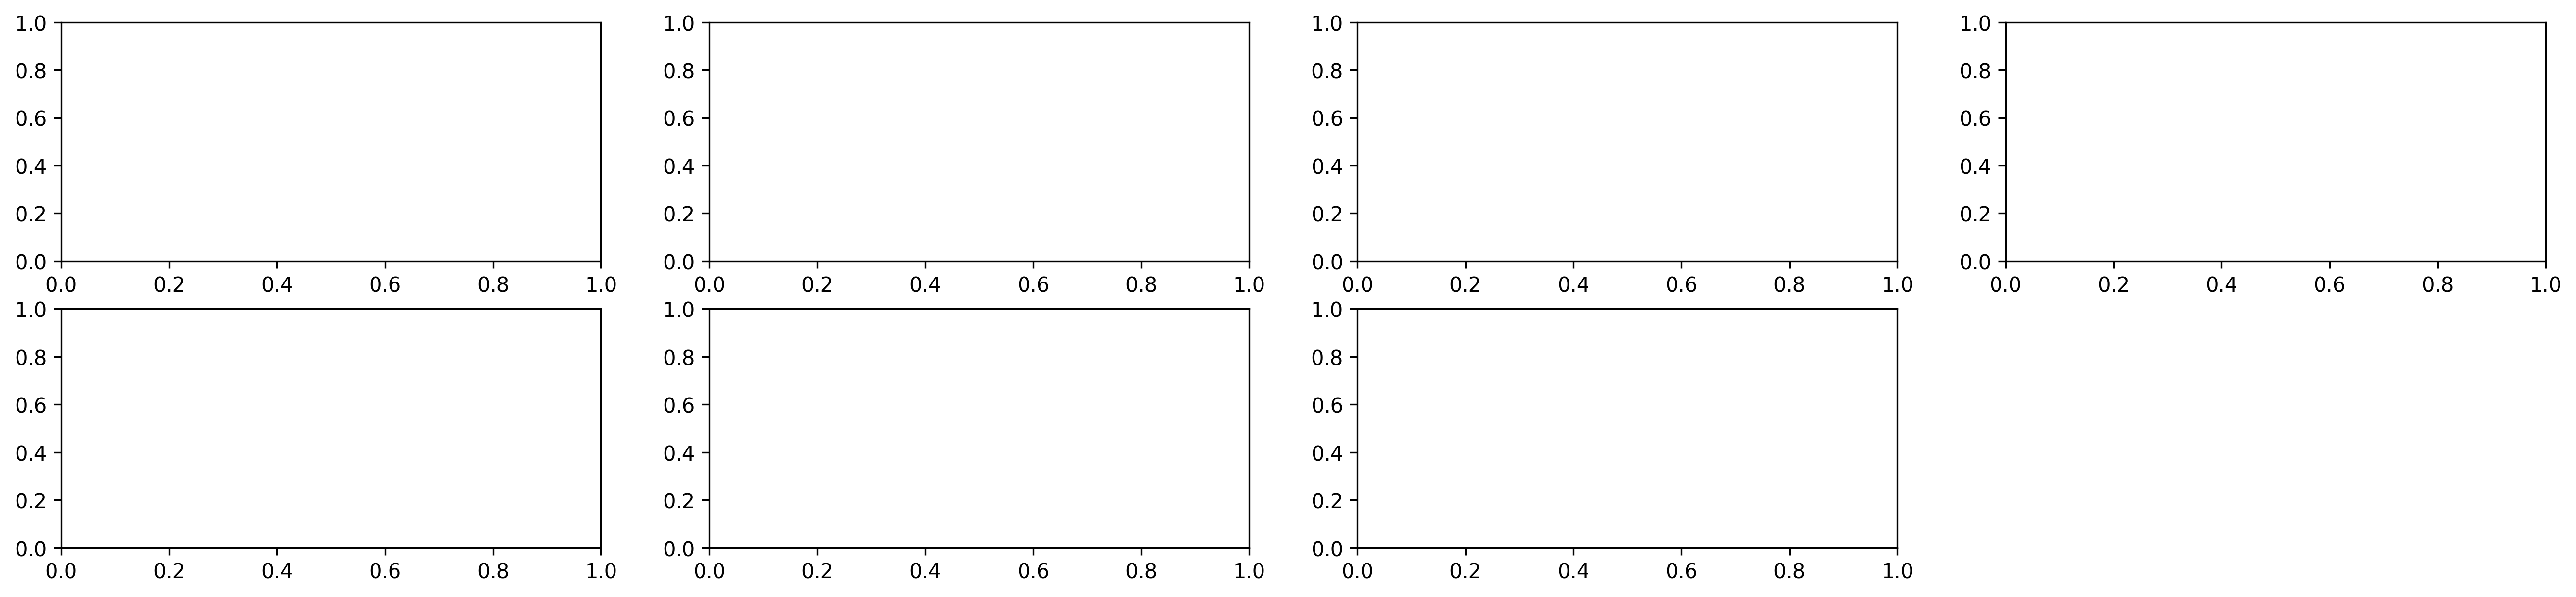

In [123]:
my_multiplots_func(my_df = my_final_df, my_vars = my_var_to_plot)

In [ ]:
my_var_to_plot[0:2]

In [ ]:
my_multiplots_func(my_var_to_plot)

In [ ]:
%who

In [ ]:
country